In [539]:
import os

local_path = os.path.join(os.getcwd(), 'data')
result_folder_path = os.path.join(os.getcwd(), 'test_results')

In [540]:
import math
import pandas as pd

df_data_size = pd.read_csv(os.path.join(result_folder_path, 'data_size.csv'), sep=';', index_col=0)

total_data_size_csv = df_data_size['input_data'].sum()
total_data_size_parquet = df_data_size['output_data'].sum()

print(f"Total size of csv files: {total_data_size_csv} Bytes, {round(total_data_size_csv/ math.pow(10, 9), 2)} GB")
print(f"Total size of parquet files: {total_data_size_parquet} Bytes, {round(total_data_size_parquet/ math.pow(10, 9), 2)} GB")
print(f"Compression factor: {round(total_data_size_csv/total_data_size_parquet, 2)}")

Total size of csv files: 185907385530 Bytes, 185.91 GB
Total size of parquet files: 32904171770 Bytes, 32.9 GB
Compression factor: 5.65


In [541]:
# Method to calculate the size of the data used for the respective test run
def calculate_data_size(row, df_data_size):
    # Index of the last file used for this test
    last_file_index = row['last_file_index']

    # Filter for all files which were used to perform this test
    relevant_data = df_data_size[df_data_size.index <= last_file_index]

    # Calculate the size of the data used for this test run
    parquet_size = round(relevant_data['output_data'].sum()/ math.pow(10, 9), 2)

    return parquet_size

In [542]:
import numpy as np

def prepare_result_data(df):
    # Calculate the size of the data used for the respective test run
    df['parquet_size'] = df.apply(lambda row: calculate_data_size(row, df_data_size), axis=1, result_type='expand')

    # Replace 0 values with NaN for failed tests, to plot them correctly
    df.loc[df['status'] == 'FAILED', :] = df.loc[df['status'] == 'FAILED', :].replace(0, np.nan)

    return df

In [543]:
import matplotlib.pyplot as plt
import matplotlib.style as style

# Plot line graph
def plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b=None, aggregated=True):

    style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6), dpi=300)

    if df_b is not None:
        plt.plot(df_a[x_column_name], df_a[y_column_name], marker='o', color='steelblue', label='Aggregated')
        plt.plot(df_b[x_column_name], df_b[y_column_name], marker='o', color='darkorange', label='Non-aggregated')
    else:
        if aggregated:
            plt.plot(df_a[x_column_name], df_a[y_column_name], marker='o', color='steelblue', label='Aggregated')
        else:
            plt.plot(df_a[x_column_name], df_a[y_column_name], marker='o', color='darkorange', label='Non-aggregated')

        plt.scatter(df_a[x_column_name][df_a[y_column_name].isna()], [0] * df_a[y_column_name].isna().sum(), color='red', marker='x')

    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(frameon=True)
    plt.grid(True)

In [544]:
import matplotlib.pyplot as plt
import matplotlib.style as style

# Adding data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot bar graph
def plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b):
    
    style.use('seaborn-v0_8-whitegrid')

    plt.figure(figsize=(10, 6), dpi=300)

    width = 0.35     
    x_positions = range(len(df_a))
    
    bars_a = plt.bar(x_positions, df_a[y_column_name], width, color='steelblue', label='Aggregated')
    bars_b = plt.bar([p + width for p in x_positions], df_b[y_column_name], width, color='darkorange', label='Non-aggregated')
    
    plt.xticks([p + width / 2 for p in x_positions], df_a[x_column_name])

    add_labels(bars_a)
    add_labels(bars_b)

    plt.title(title, fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend(frameon=True)

    plt.show()

In [545]:
# Result data of data volume scalability tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_data_volume_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of data volume scalability tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_data_volume_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

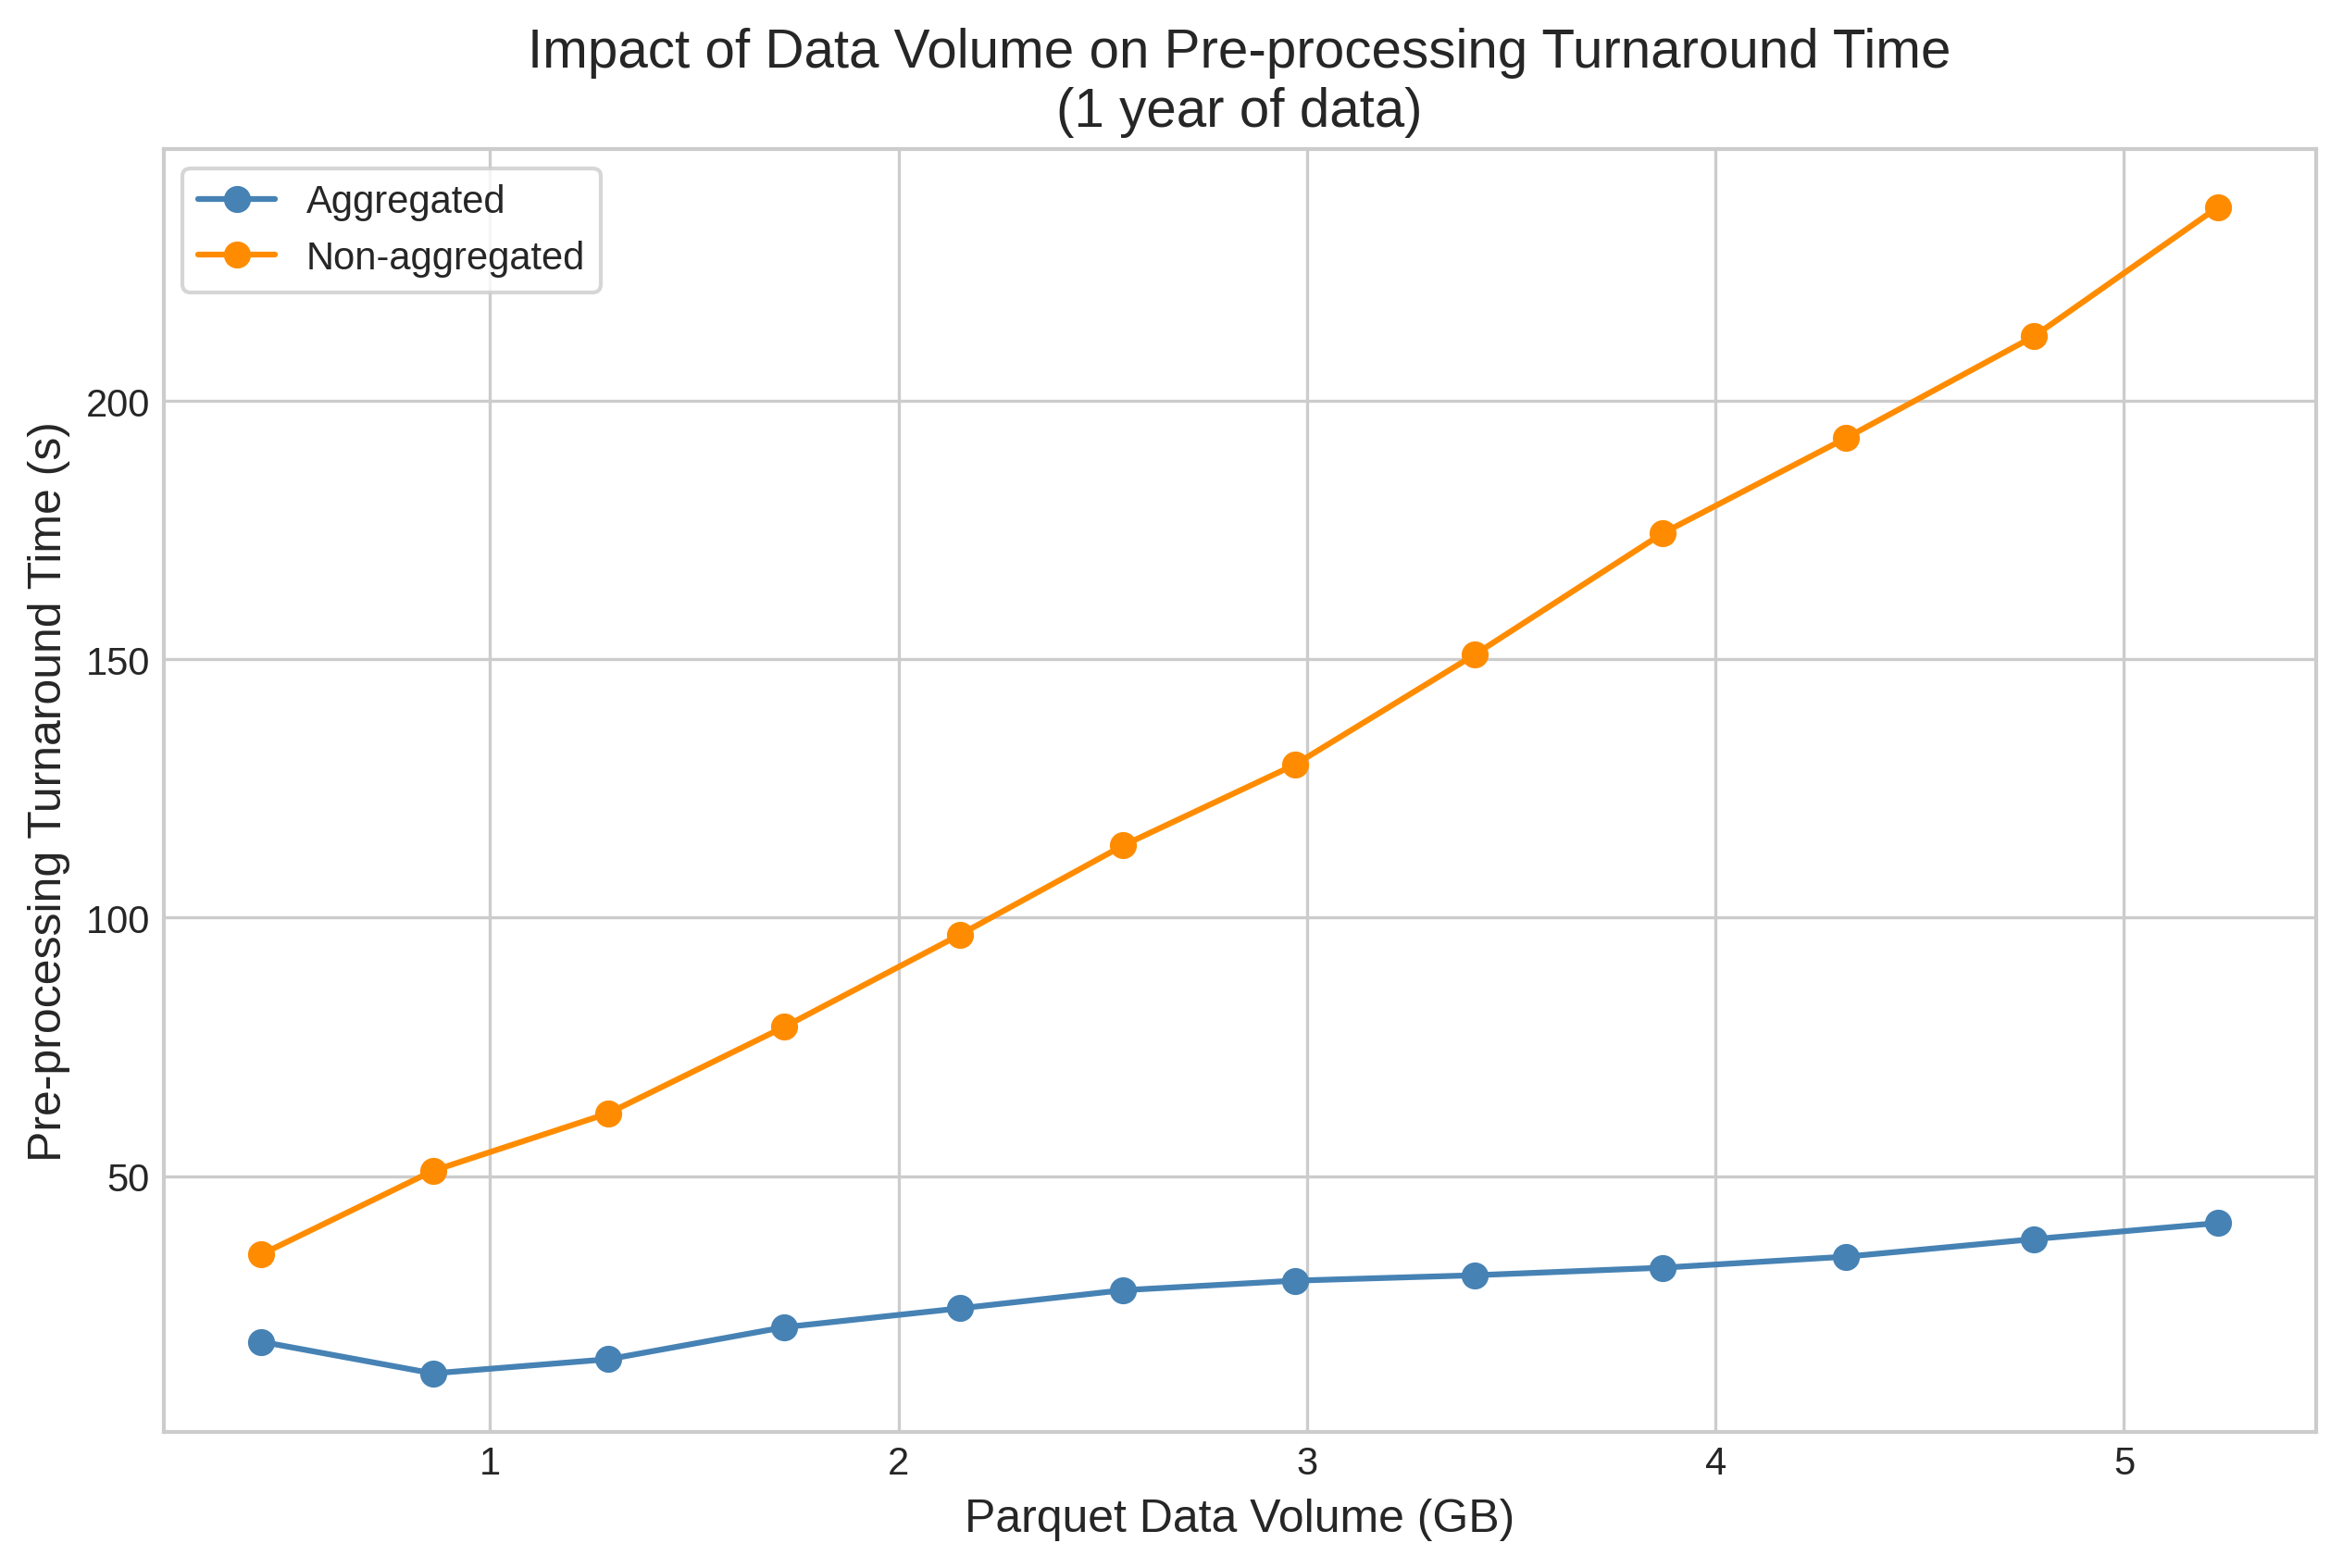

In [546]:
# Filter for 1 year of data
df_a = df_result_aggregated.where(df_result_aggregated['last_file_index'] <= 11)
df_b = df_result_non_aggregated.where(df_result_non_aggregated['last_file_index'] <= 11)

x_column_name = 'parquet_size'
y_column_name = 'duration'

title = 'Impact of Data Volume on Pre-processing Turnaround Time\n(1 year of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Pre-processing Turnaround Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)
plt.show()

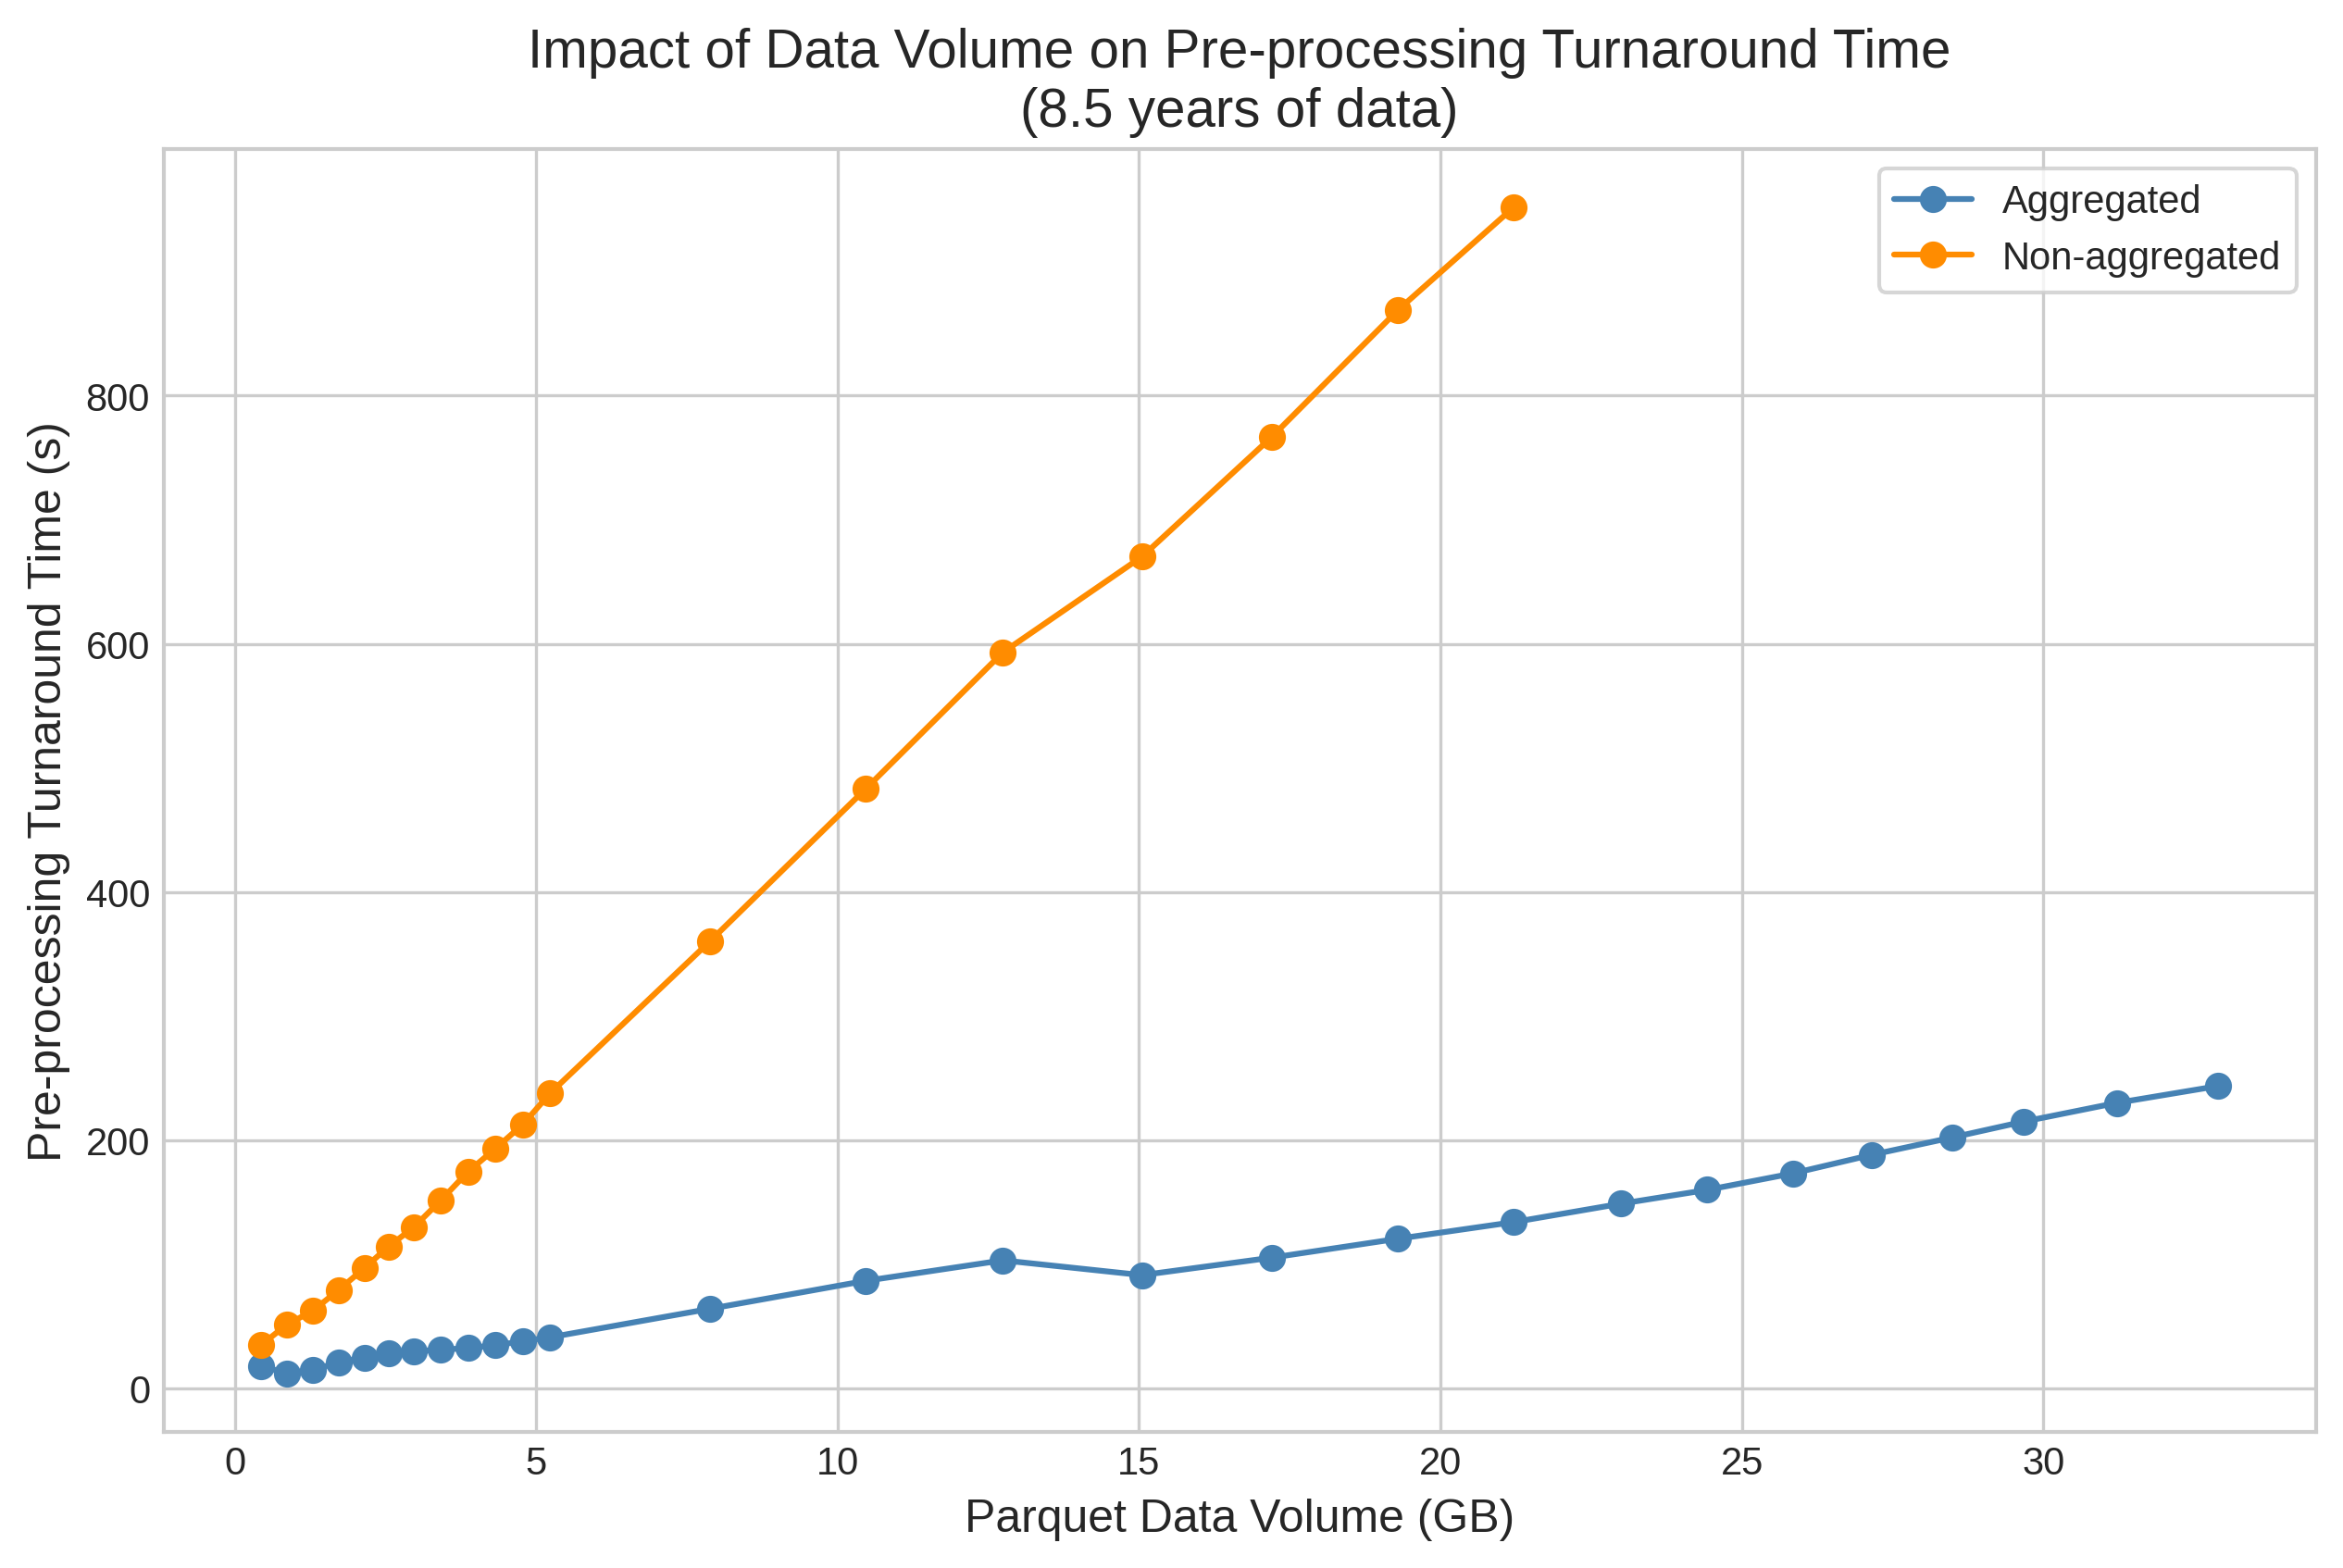

In [547]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'parquet_size'
y_column_name = 'duration'

title = 'Impact of Data Volume on Pre-processing Turnaround Time\n(8.5 years of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Pre-processing Turnaround Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

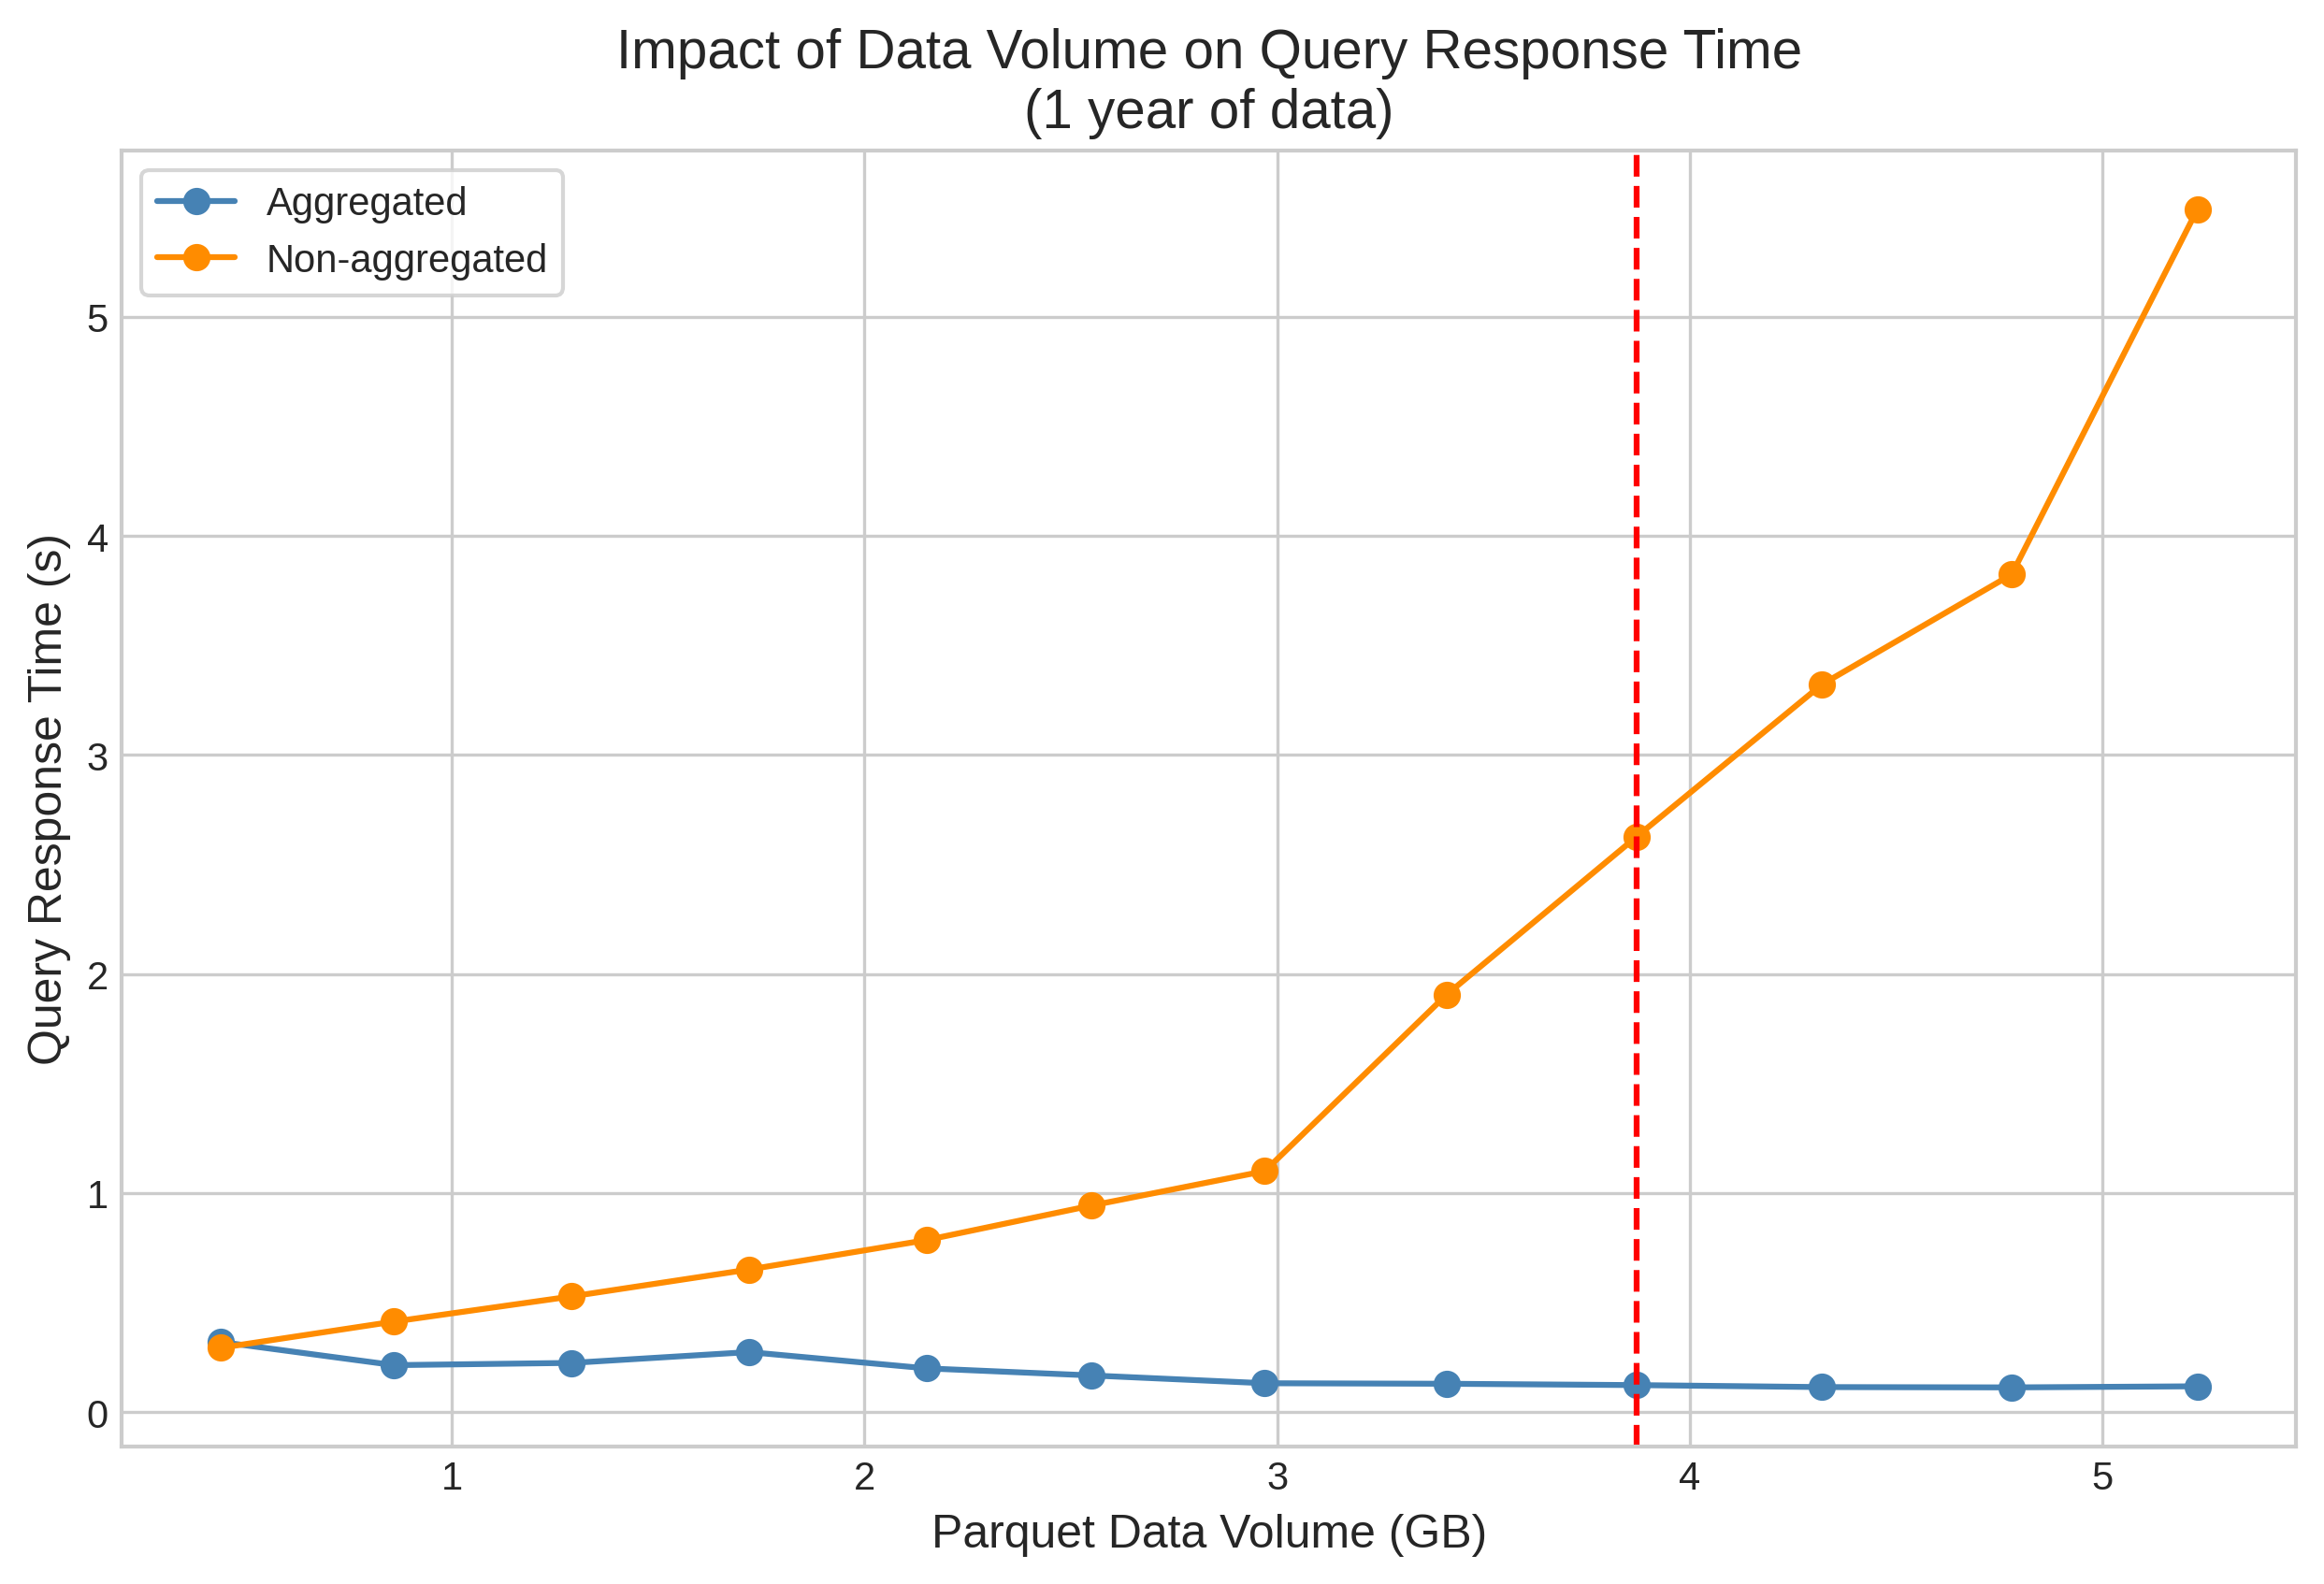

In [548]:
# Filter for 1 year of data
df_a = df_result_aggregated.where(df_result_aggregated['last_file_index'] <= 11)
df_b = df_result_non_aggregated.where(df_result_non_aggregated['last_file_index'] <= 11)

x_column_name = 'parquet_size'
y_column_name = 'avg_req_time'

title = 'Impact of Data Volume on Query Response Time\n(1 year of data)'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

# Add a vertical line where the disk is used for caching for the first time
disk_used_for_cache = df_b[df_b['disk_usage'] > 0][x_column_name].iloc[0]
plt.axvline(x=disk_used_for_cache, color='r', linestyle='--')

plt.show()

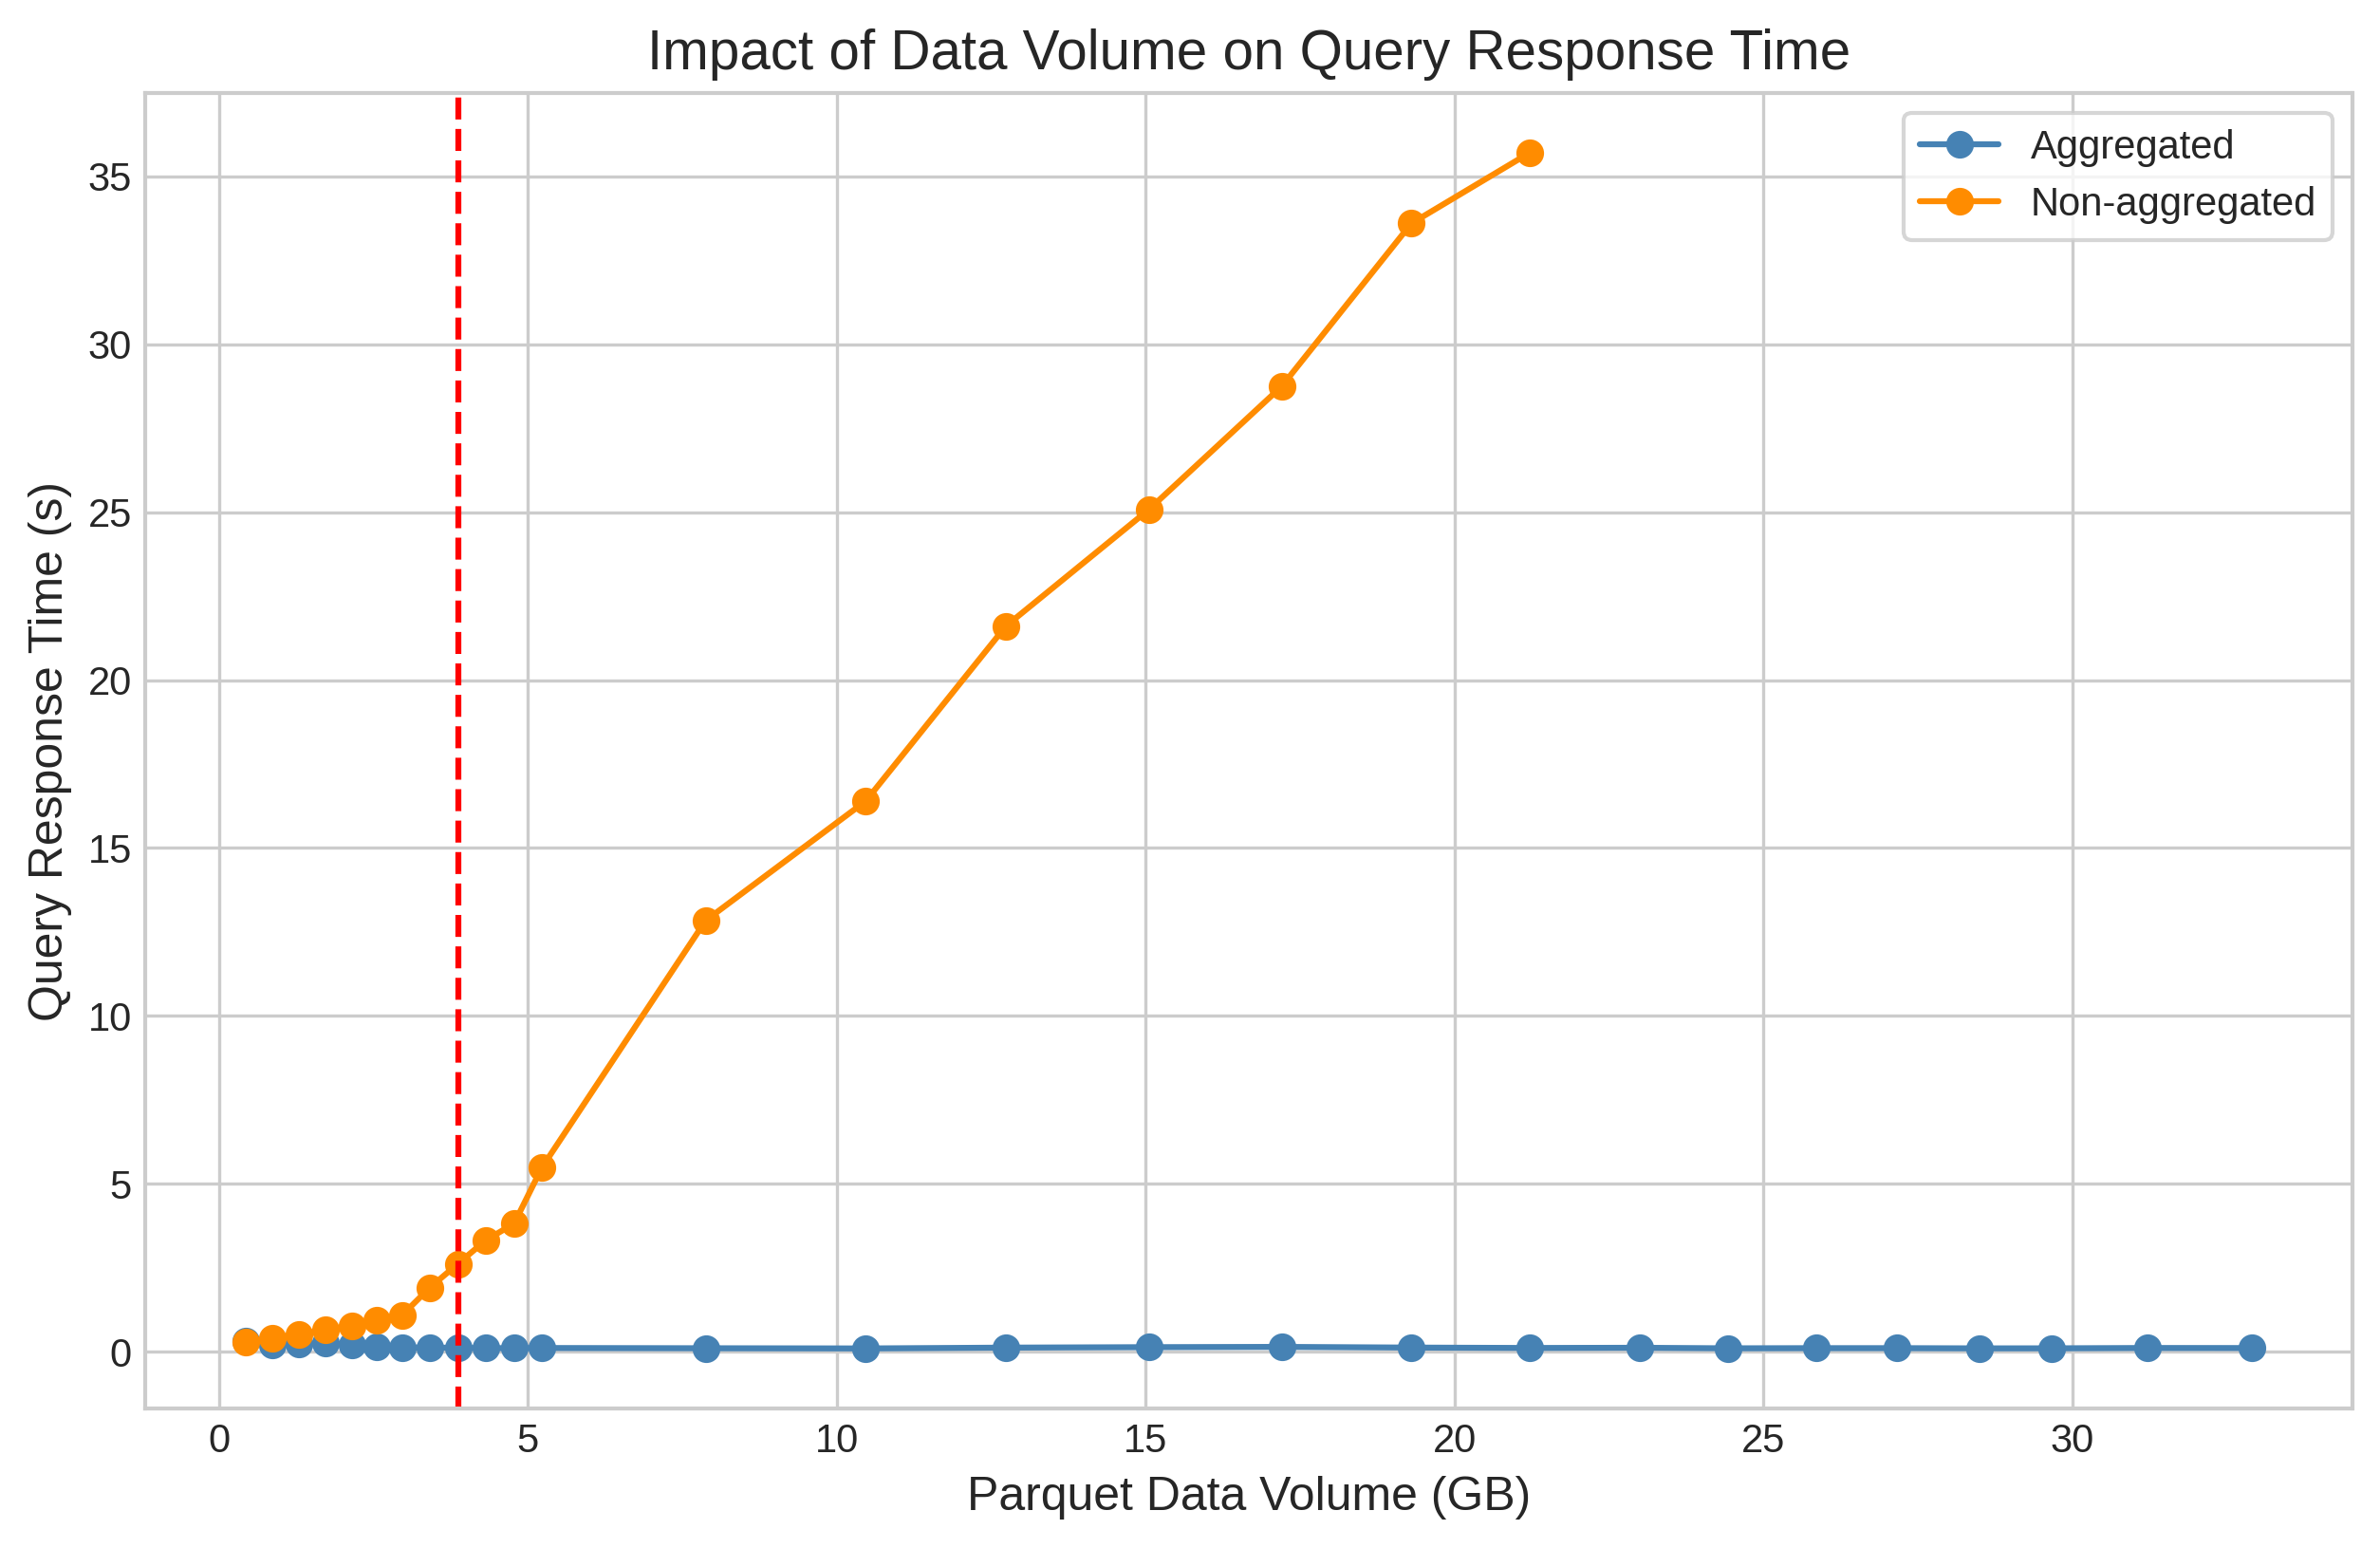

In [549]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'parquet_size'
y_column_name = 'avg_req_time'

title = 'Impact of Data Volume on Query Response Time'
x_label = 'Parquet Data Volume (GB)'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

# Add a vertical line where the disk is used for caching for the first time
disk_used_for_cache = df_b[df_b['disk_usage'] > 0][x_column_name].iloc[0]
plt.axvline(x=disk_used_for_cache, color='r', linestyle='--')

plt.show()

In [550]:
# Result data of data volume scalability tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_load_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of data volume scalability tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_load_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

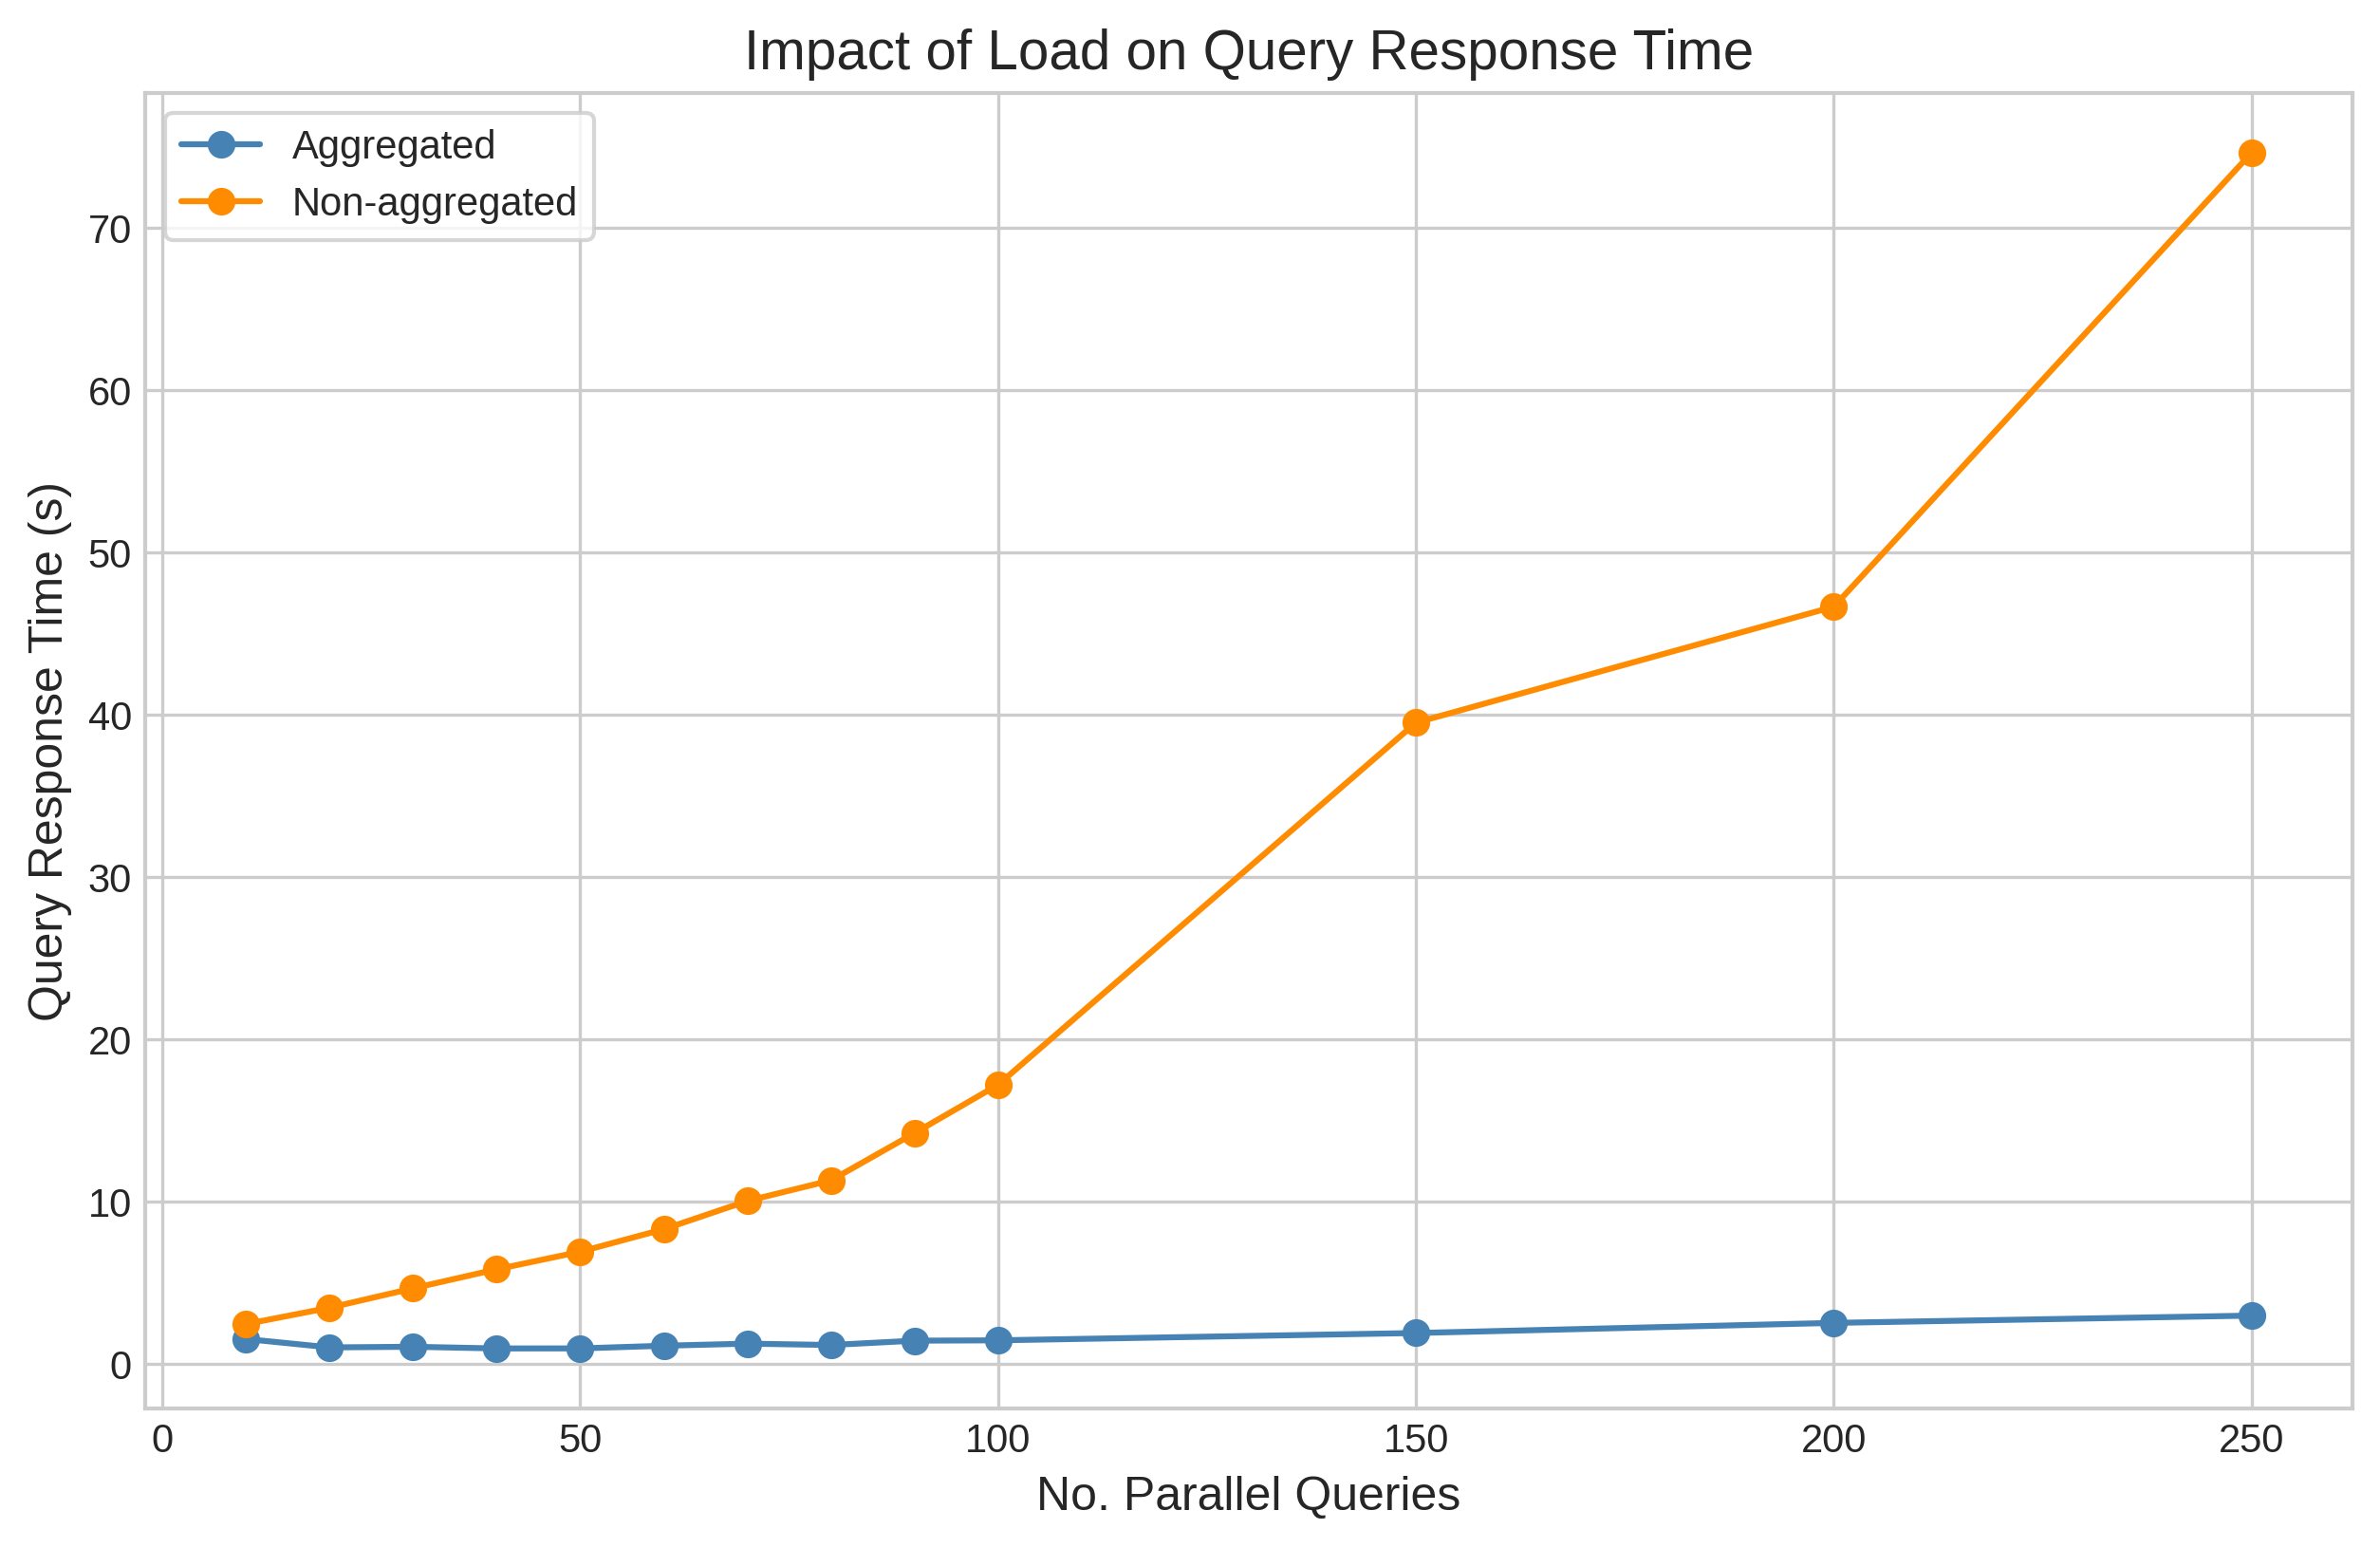

In [551]:
# Filter for 250 parallel queries
df_a = df_result_aggregated.where(df_result_aggregated['parallel_queries'] <= 250)
df_b = df_result_non_aggregated.where(df_result_non_aggregated['parallel_queries'] <= 250)

x_column_name = 'parallel_queries'
y_column_name = 'avg_req_time'

title = 'Impact of Load on Query Response Time'
x_label = 'No. Parallel Queries'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

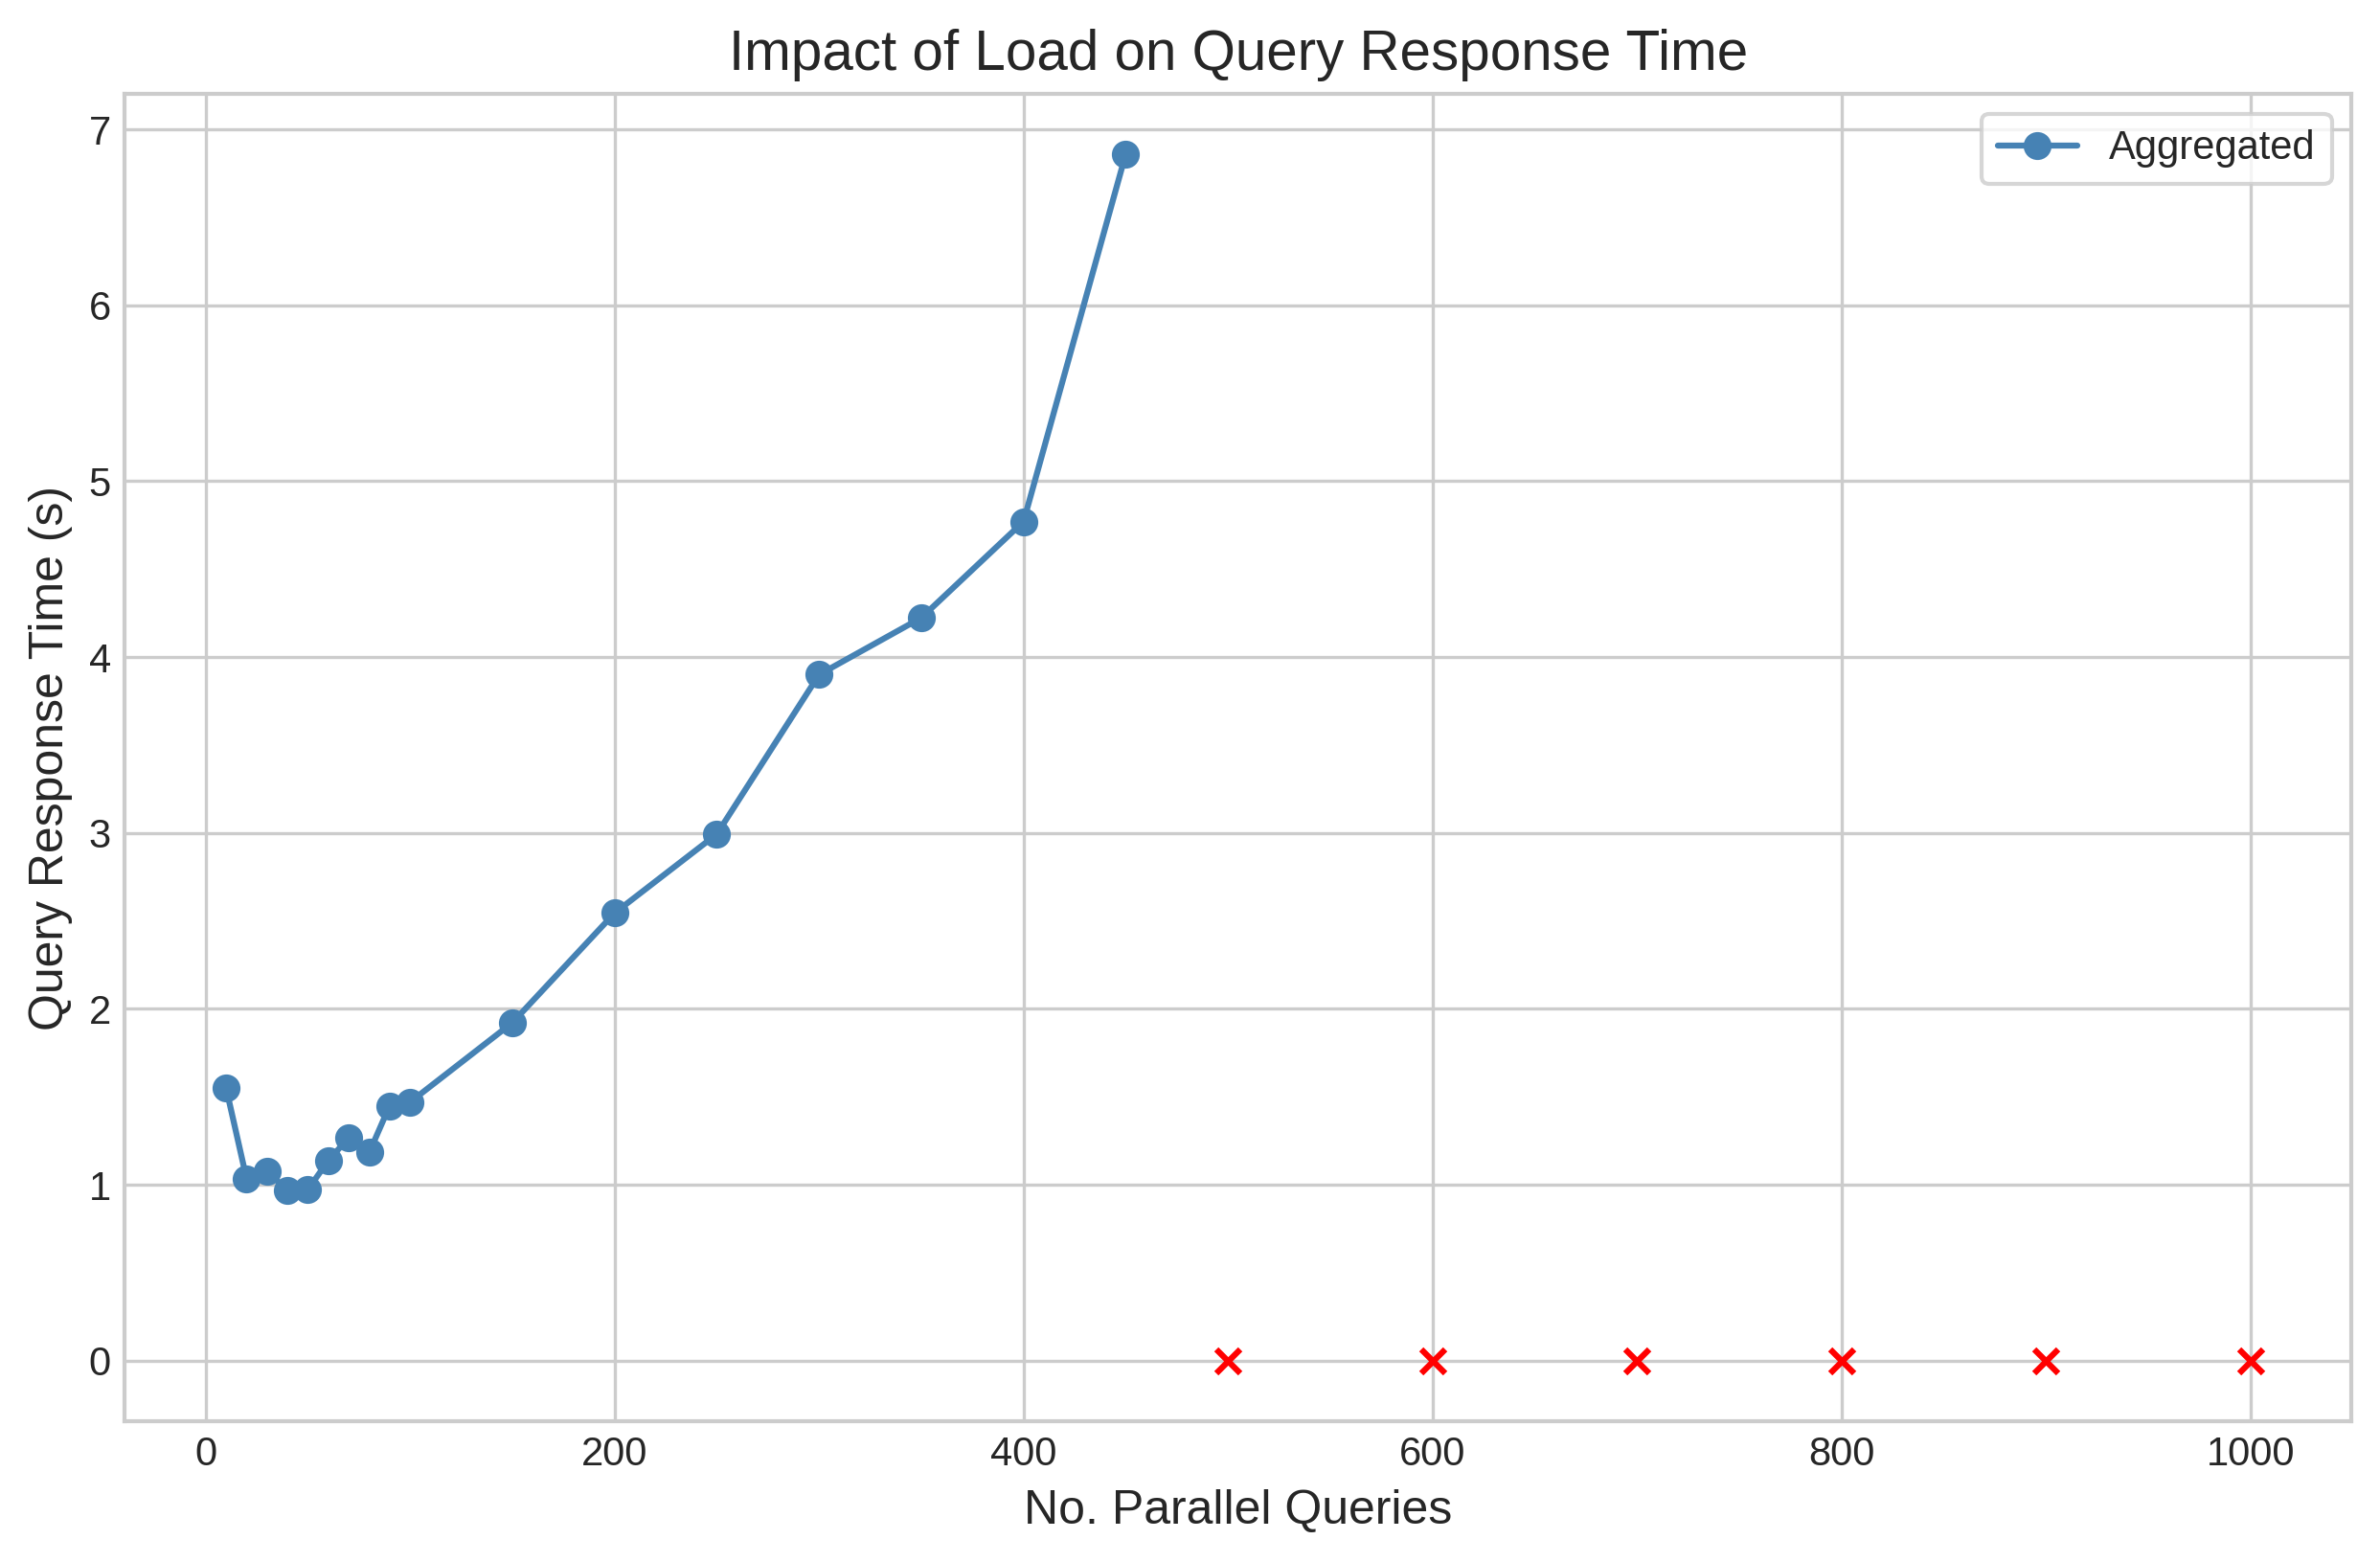

In [552]:
df_a = df_result_aggregated

x_column_name = 'parallel_queries'
y_column_name = 'avg_req_time'

title = 'Impact of Load on Query Response Time'
x_label = 'No. Parallel Queries'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a)

plt.show()

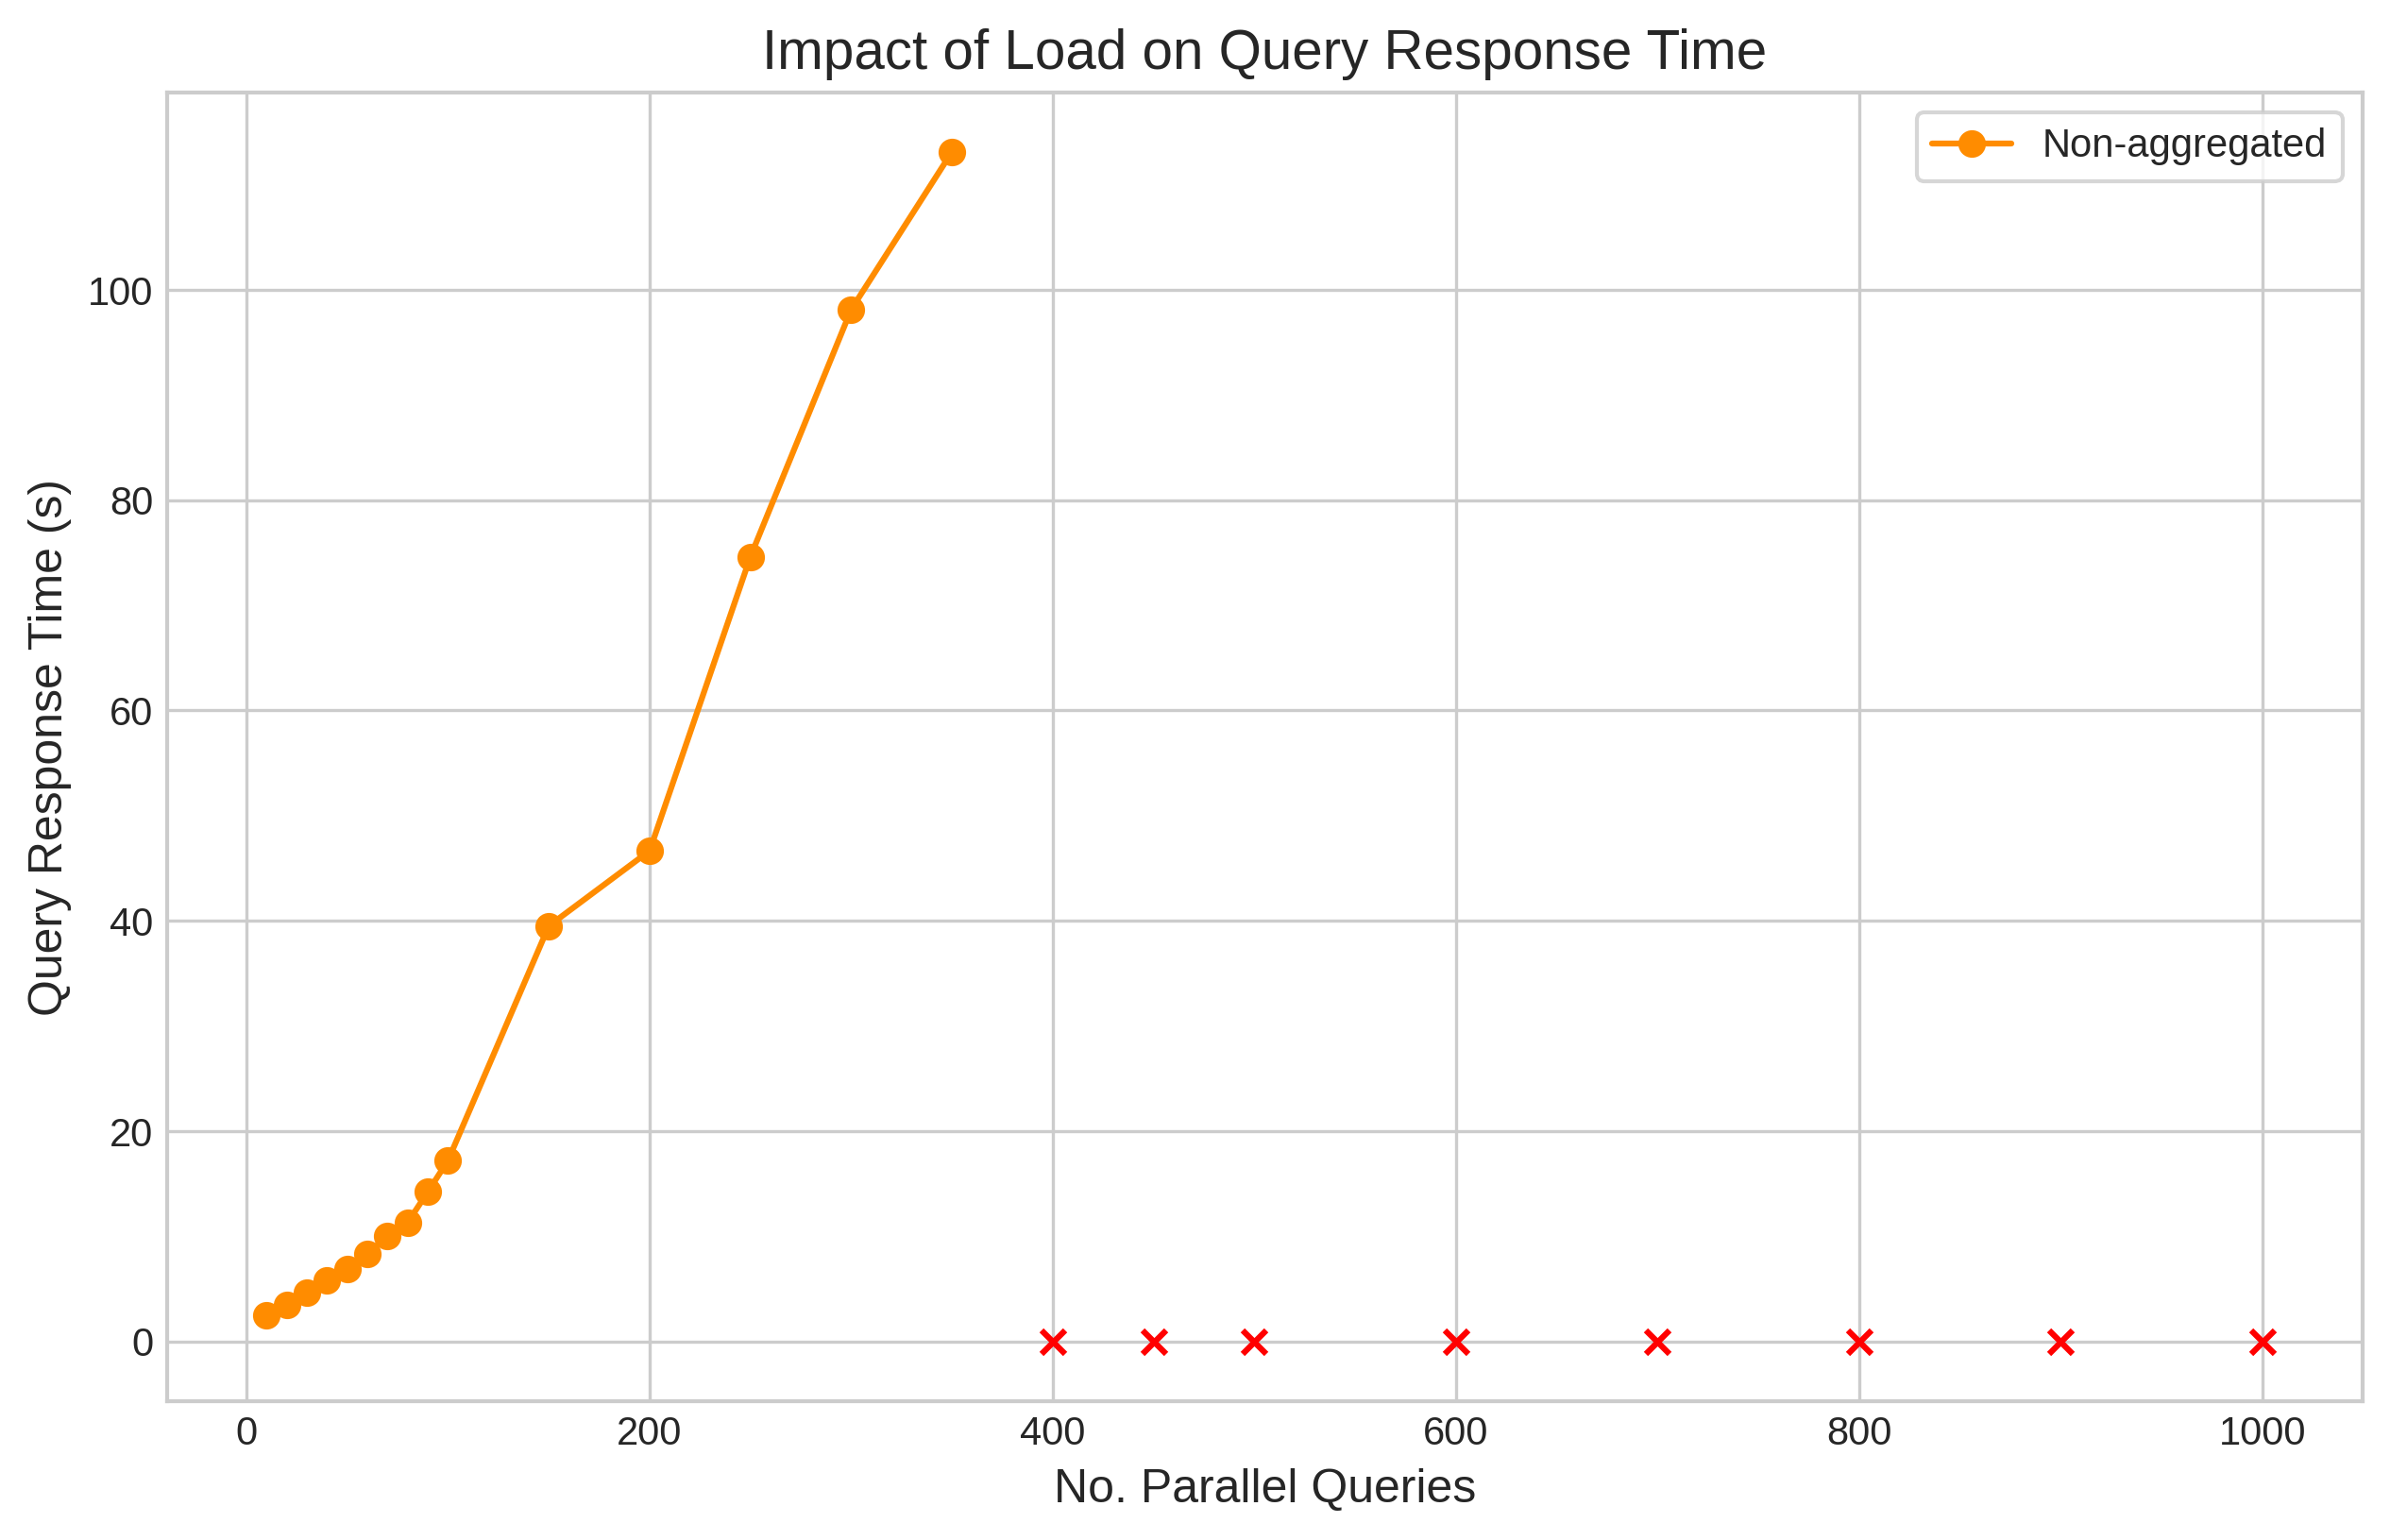

In [553]:
df_a = df_result_non_aggregated

x_column_name = 'parallel_queries'
y_column_name = 'avg_req_time'

title = 'Impact of Load on Query Response Time'
x_label = 'No. Parallel Queries'
y_label = 'Query Response Time (s)'

plot_line_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, aggregated=False)

plt.show()

In [554]:
# Result data of resource scalability tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_resources_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of resource scalability tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_resources_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

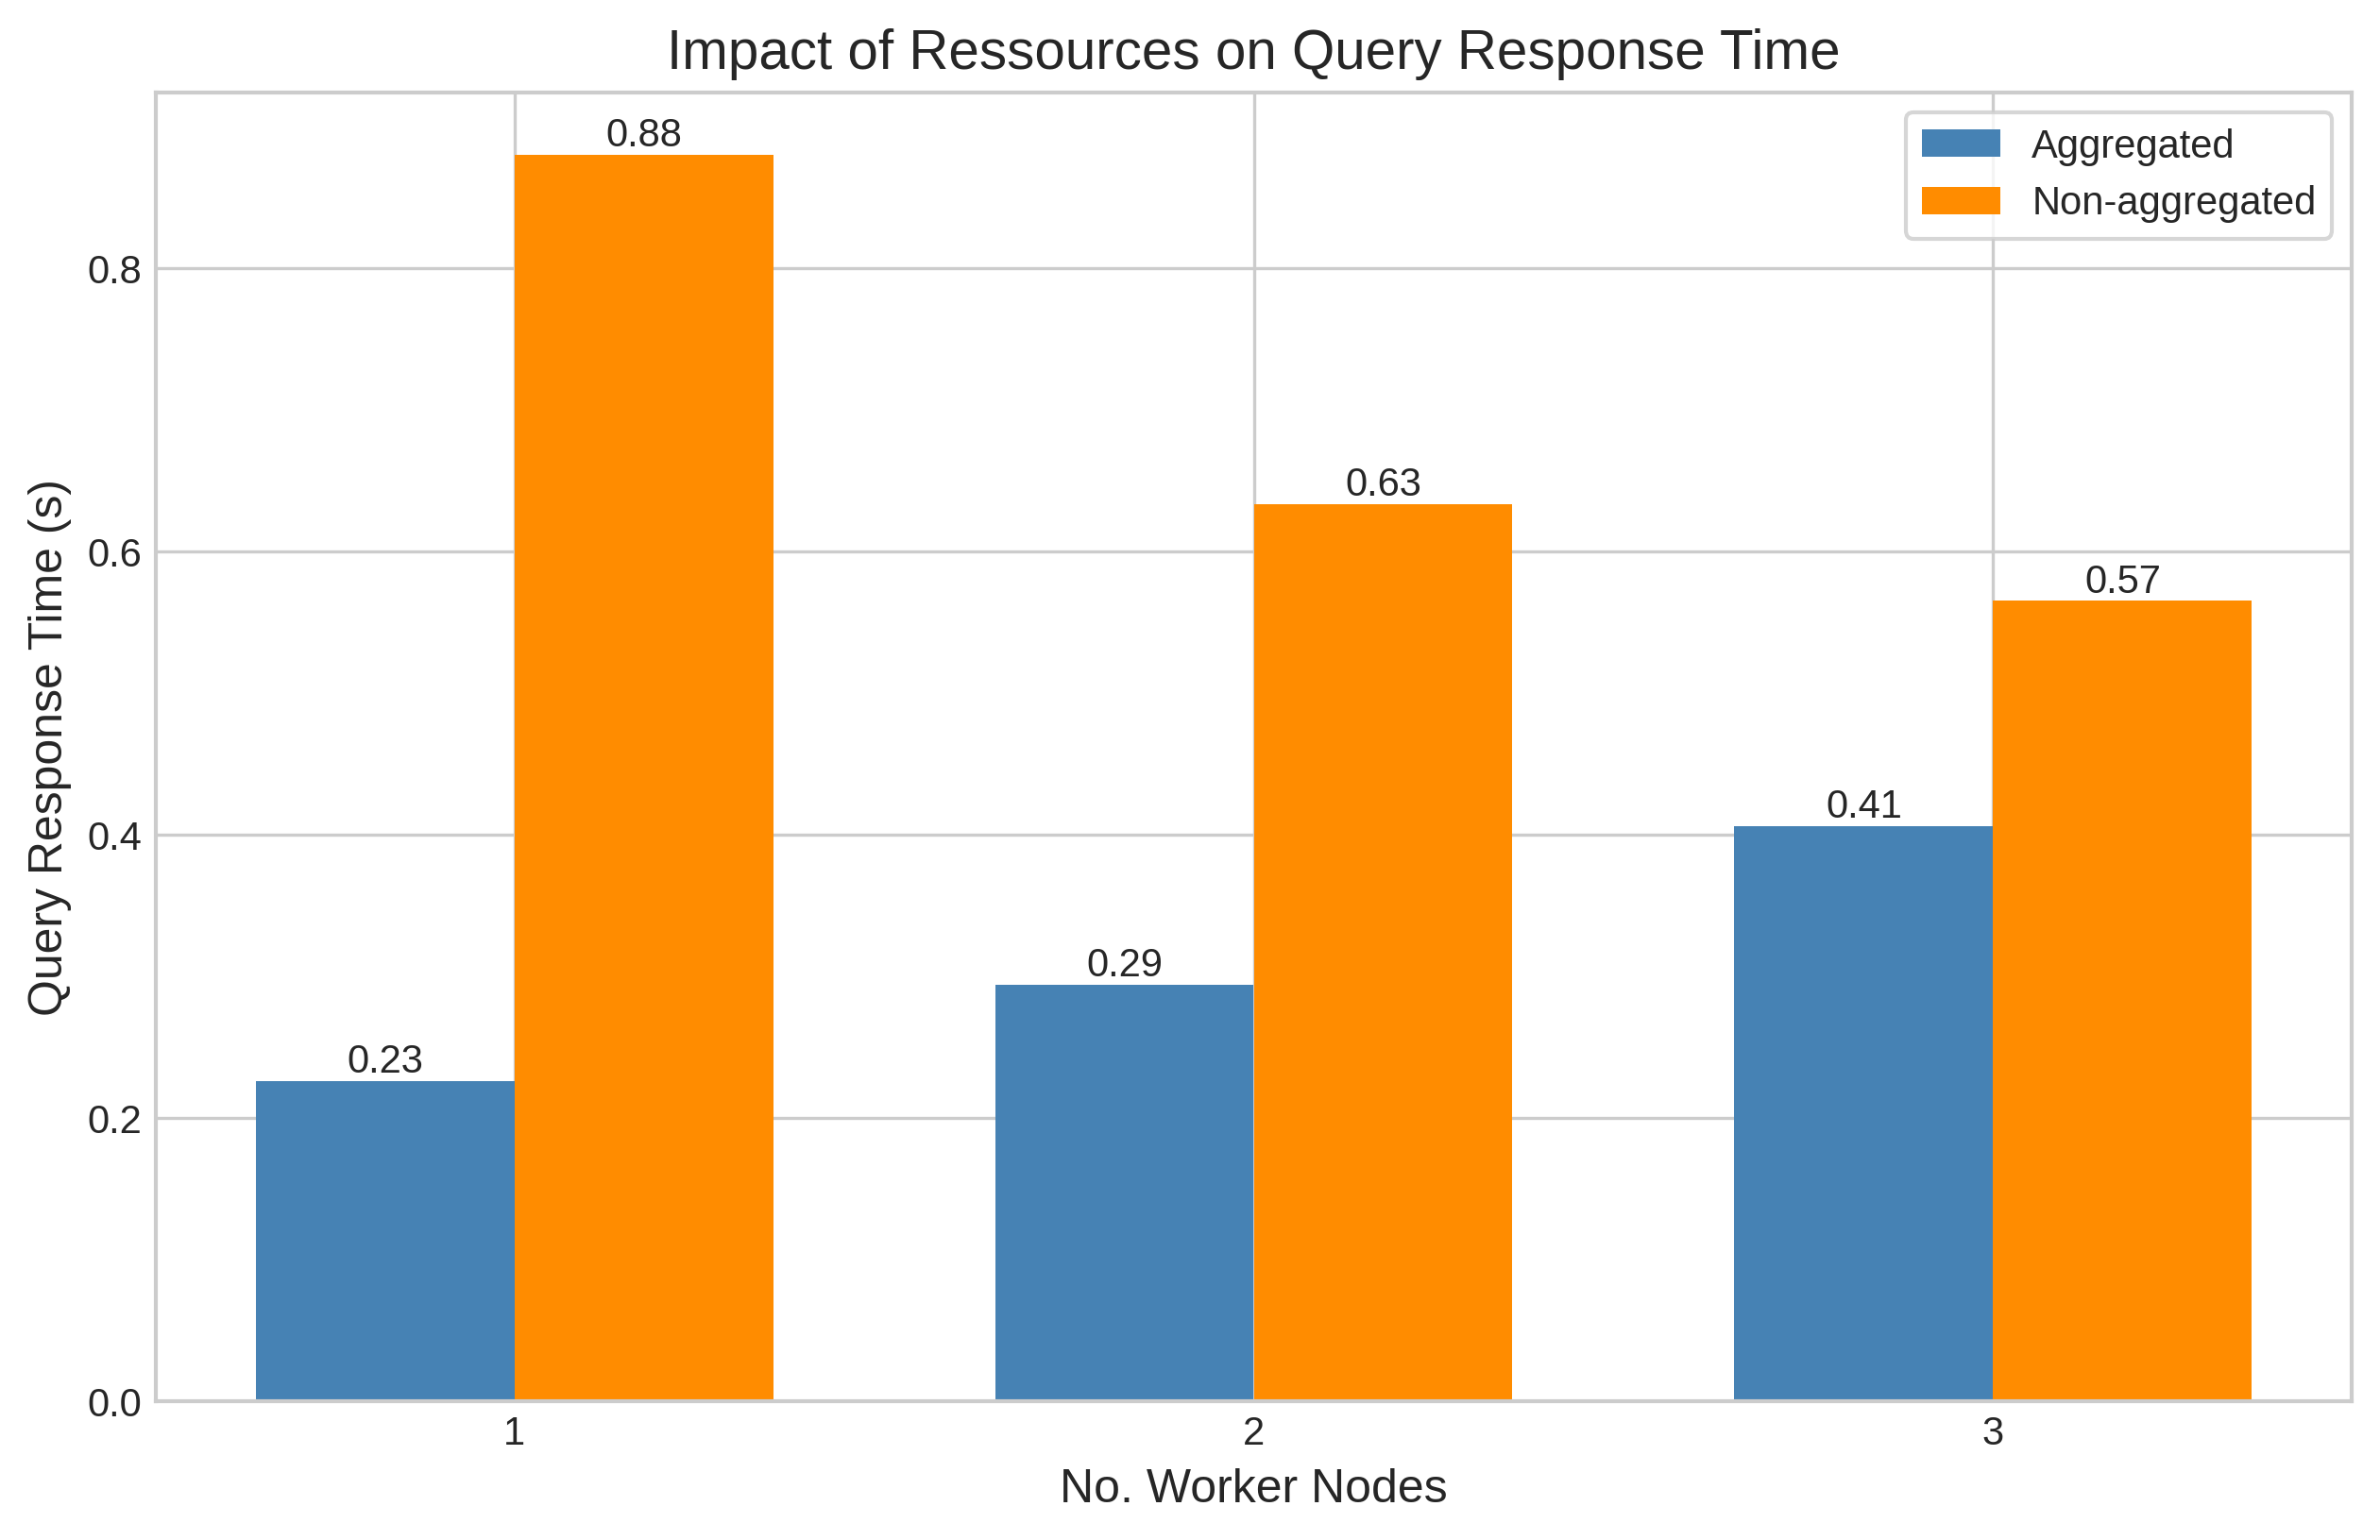

In [555]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'workers'
y_column_name = 'avg_req_time'

title = 'Impact of Ressources on Query Response Time'
x_label = 'No. Worker Nodes'
y_label = 'Query Response Time (s)'

plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

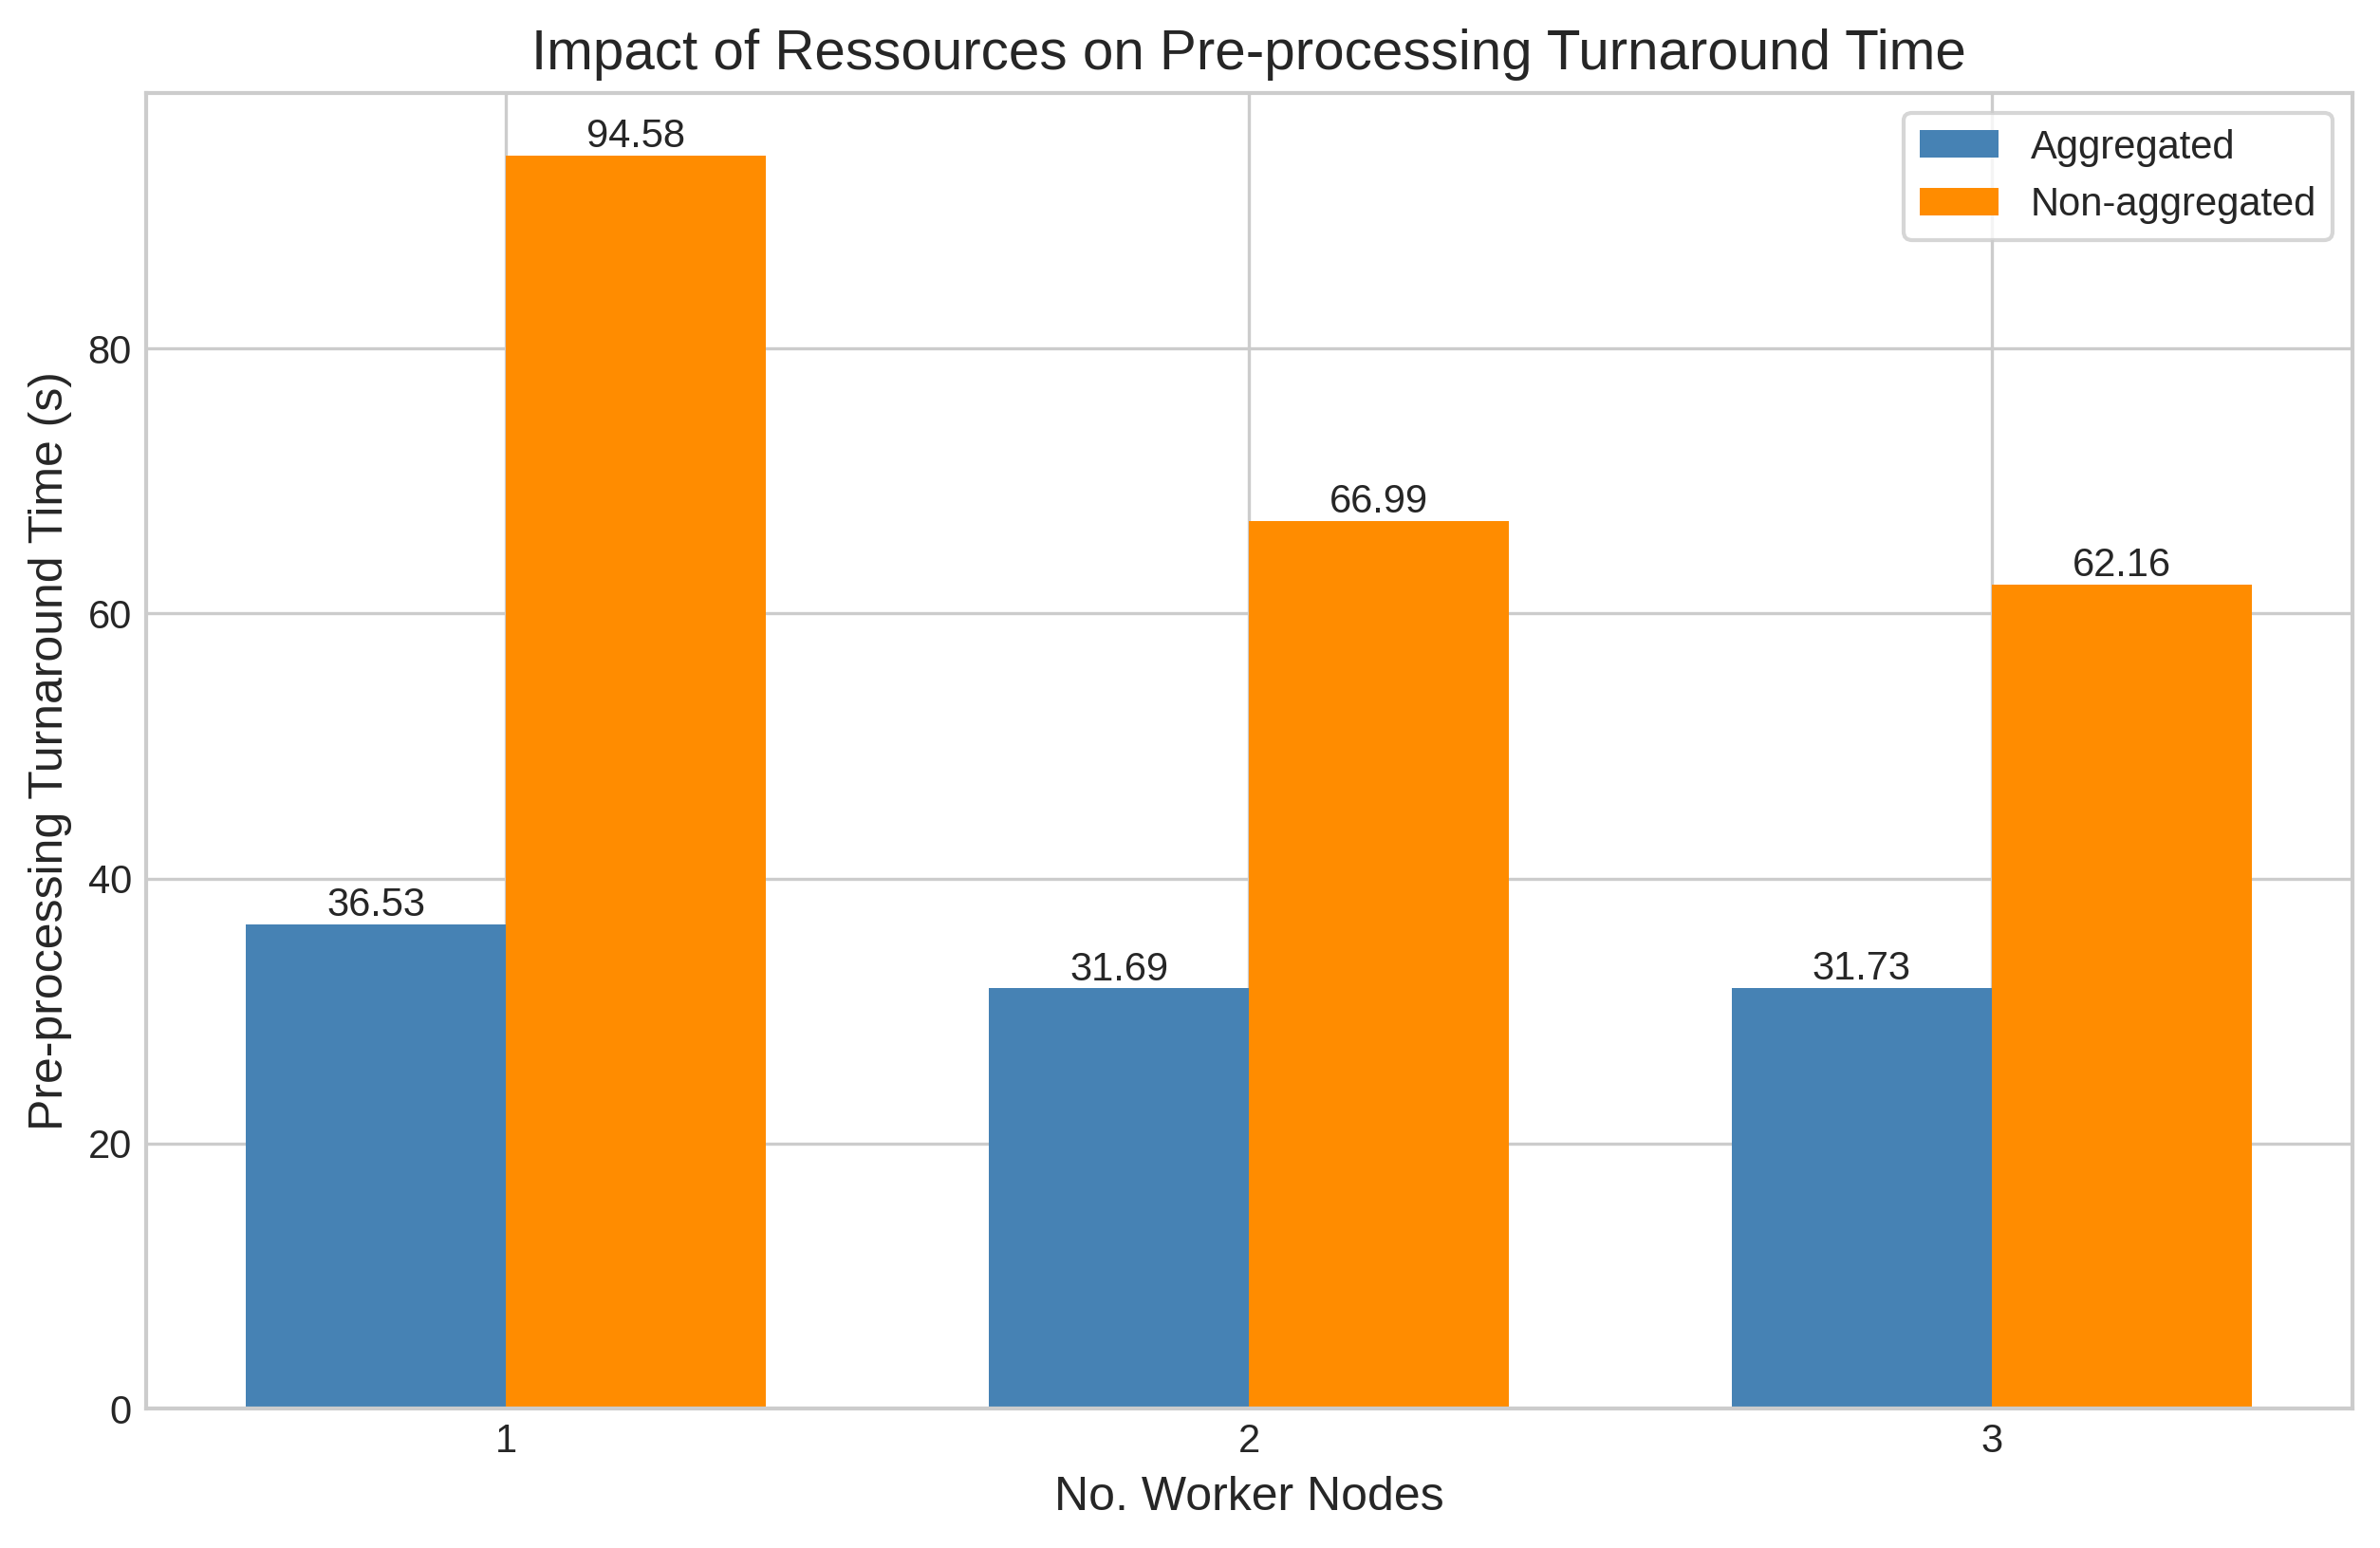

In [556]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'workers'
y_column_name = 'duration'

title = 'Impact of Ressources on Pre-processing Turnaround Time'
x_label = 'No. Worker Nodes'
y_label = 'Pre-processing Turnaround Time (s)'

plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()

In [557]:
# Result data of fault tolerance tests (aggregated)
df_result_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_fault_tolerance_aggregated.csv'), sep=';', index_col=0)
df_result_aggregated = prepare_result_data(df_result_aggregated)

# Result data of fault tolerance tests (non-aggregated)
df_result_non_aggregated = pd.read_csv(os.path.join(result_folder_path, 'test_fault_tolerance_non_aggregated.csv'), sep=';', index_col=0)
df_result_non_aggregated = prepare_result_data(df_result_non_aggregated)

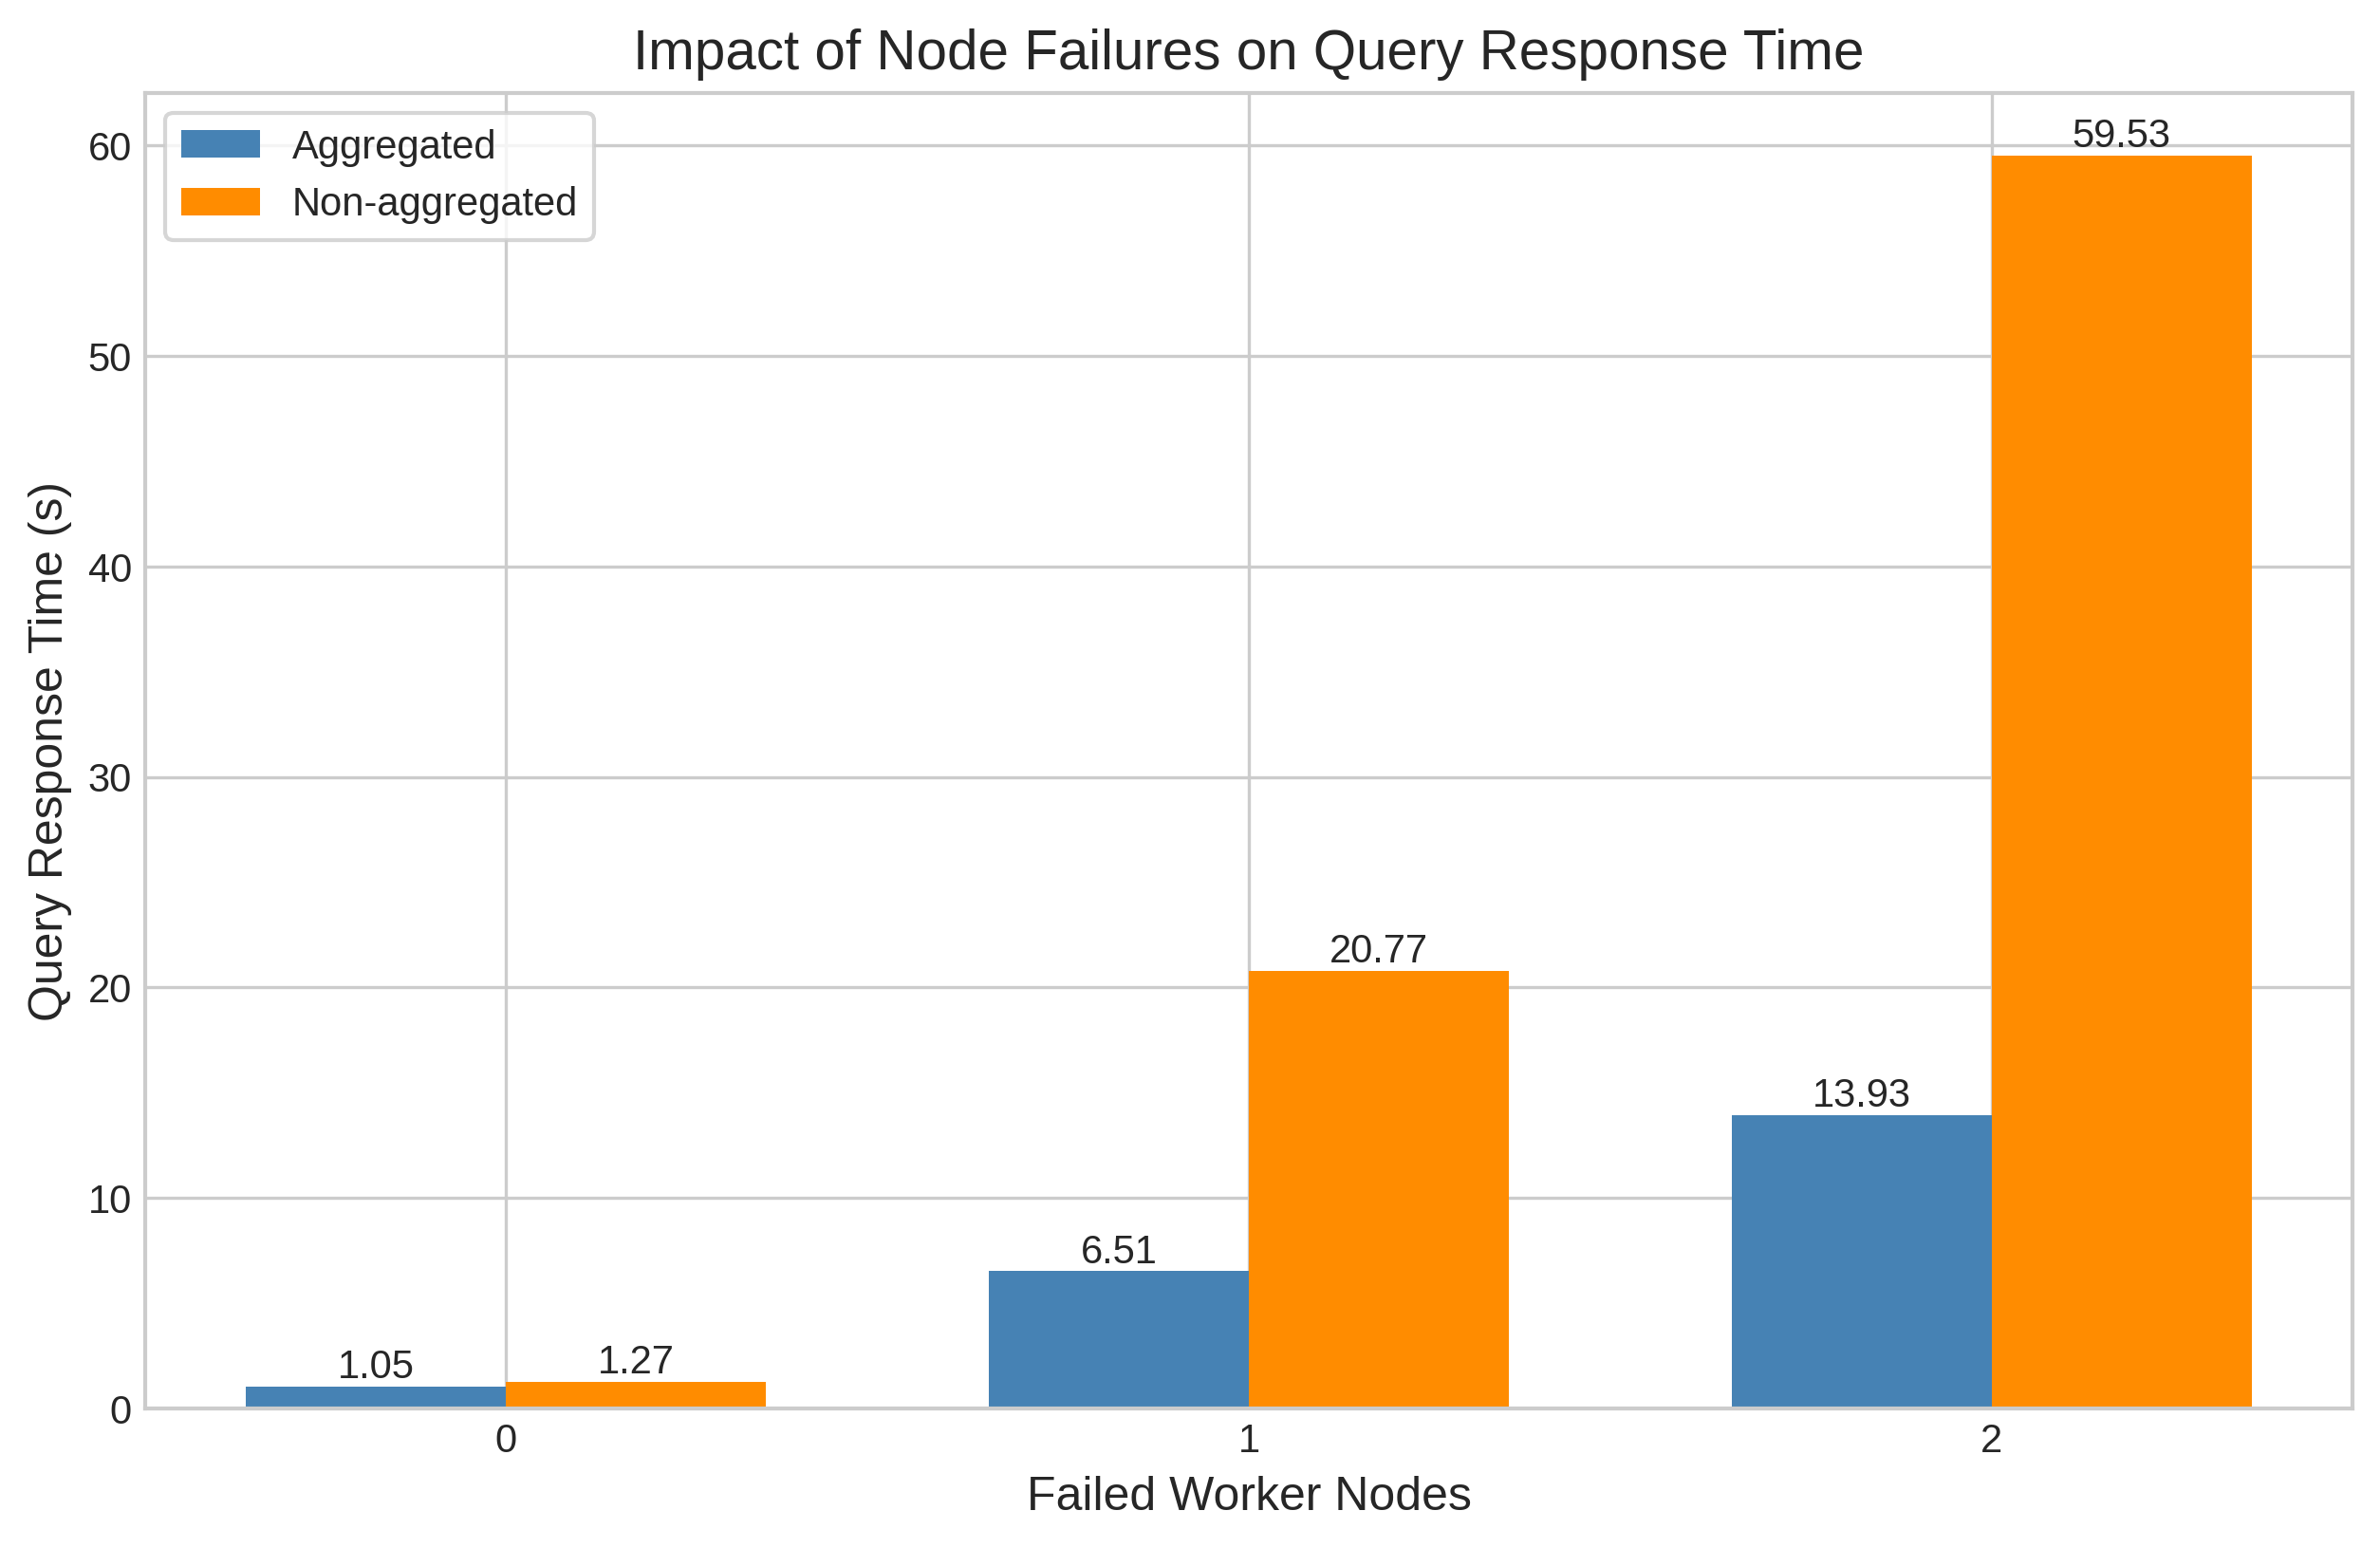

In [558]:
df_a = df_result_aggregated
df_b = df_result_non_aggregated

x_column_name = 'stopped_workers'
y_column_name = 'avg_req_time'

title = 'Impact of Node Failures on Query Response Time'
x_label = 'Failed Worker Nodes'
y_label = 'Query Response Time (s)'

plot_bar_graph(x_column_name, y_column_name, title, x_label, y_label, df_a, df_b)

plt.show()